Code is fully created by Maulana Zulfikar Aziz (maulanazulfikarrz@gmail.com)

In [ ]:
# Import libraries yang dibutuhkan

import pandas as pd
import numpy as np
import re
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import uniform, randint
from sklearn.preprocessing import StandardScaler

In [ ]:
data_train = pd.read_csv("application_train.csv")
data_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


--- Jumlah Absolut TARGET (0 dan 1) ---
TARGET
0    282686
1     24825
Name: count, dtype: int64

--- Proporsi/Persentase TARGET ---
TARGET
0    91.93
1     8.07
Name: proportion, dtype: float64


C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\2176742577.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


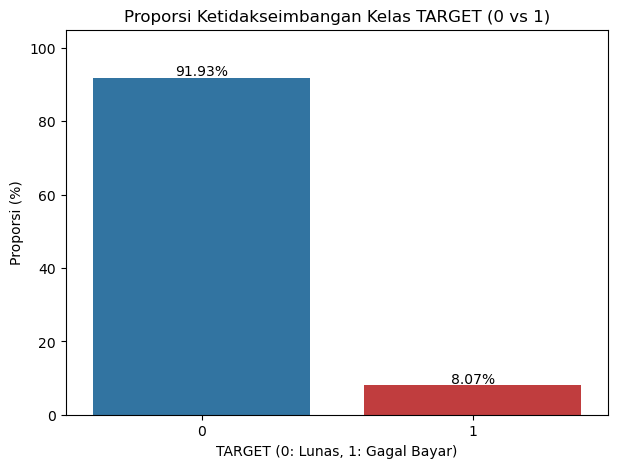

In [ ]:
# Membuat grafik untuk melihat proporsi ketidakseimbangan kelas TARGET (0 vs 1)
target_counts = data_train['TARGET'].value_counts()
target_proportions = data_train['TARGET'].value_counts(normalize=True) * 100

print("--- Jumlah Absolut TARGET (0 dan 1) ---")
print(target_counts)

print("\n--- Proporsi/Persentase TARGET ---")
print(target_proportions.round(2))

# Simpan hasil proporsi ke DataFrame untuk visualisasi
df_proportions = target_proportions.reset_index()
df_proportions.columns = ['TARGET', 'Proporsi (%)']

plt.figure(figsize=(7, 5))
sns.barplot(
    x='TARGET',
    y='Proporsi (%)',
    data=df_proportions,
    palette=['#1f77b4', '#d62728'] # Biru untuk 0 (Lunas), Merah untuk 1 (Gagal Bayar)
)

# Menambahkan label nilai di atas setiap bar
for index, row in df_proportions.iterrows():
    plt.text(
        row.name,
        row['Proporsi (%)'] + 0.5,
        f"{row['Proporsi (%)']:.2f}%",
        color='black',
        ha="center"
    )

plt.title('Proporsi Ketidakseimbangan Kelas TARGET (0 vs 1)')
plt.xlabel('TARGET (0: Lunas, 1: Gagal Bayar)')
plt.ylabel('Proporsi (%)')
plt.ylim(0, 105)
plt.show()

C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\236245551.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\236245551.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\236245551.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


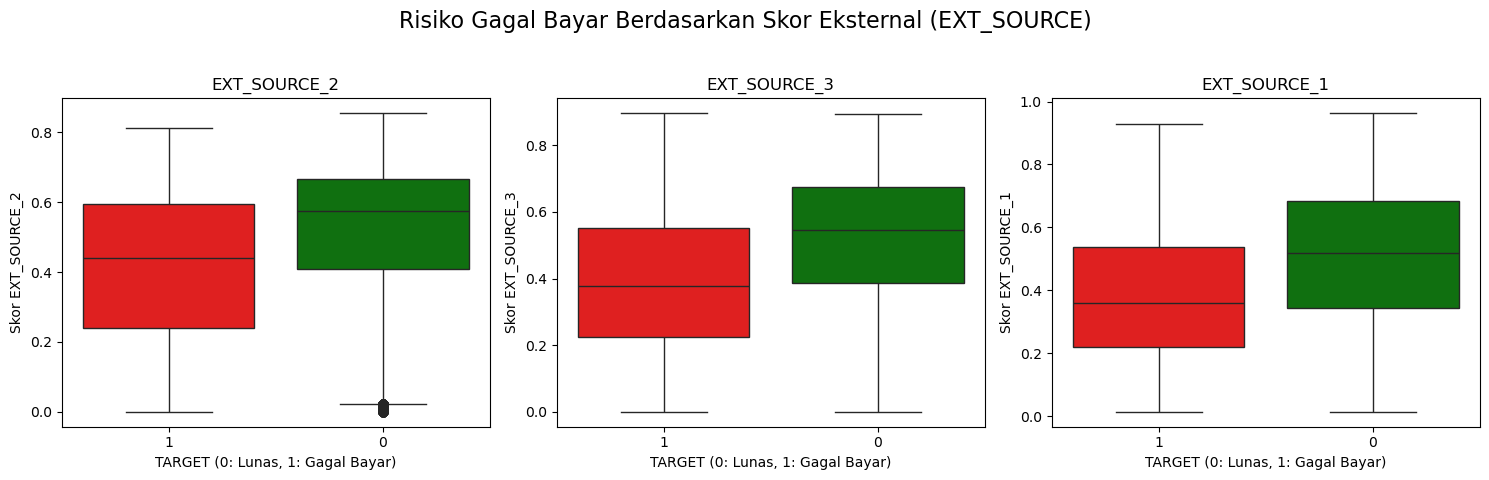

In [ ]:
# Membuat boxplot untuk melihat persebaran data masing-masing EXT_SOURCE terhadap TARGET

data_train['TARGET'] = data_train['TARGET'].astype(str)

palette_dict = {'0': 'green', '1': 'red'}
EXT_SOURCE_COLS = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1']

plt.figure(figsize=(15, 5))
plt.suptitle('Risiko Gagal Bayar Berdasarkan Skor Eksternal (EXT_SOURCE)', fontsize=16)

for i, col in enumerate(EXT_SOURCE_COLS):
    plt.subplot(1, 3, i + 1)

    sns.boxplot(
        x='TARGET',
        y=col,
        data=data_train,
        palette=palette_dict  # <--- Menggunakan dictionary yang sudah didefinisikan dengan kunci STRING
    )

    plt.title(f'{col}')
    plt.xlabel('TARGET (0: Lunas, 1: Gagal Bayar)')
    plt.ylabel(f'Skor {col}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
data_test = pd.read_csv("application_test.csv")
data_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


Analisis dilakukan dengan membersihkan sekaligus melakukan Feature Engineering pada masing-masing file csv yang kemudian nantinya fitur hasil Feature Engineering digabungkan dengan file train.csv menggunakan key SK_ID_CURR. Setelah itu dilakukan proses Feature Selection menggunakan model LightGBM dan dilanjutkan dengan pembuatan model Logistic Regression, XGBoost, Random Forest, dan LightGBM. Di bagian akhir, feature importances pada model terbaik akan dihitung untuk selanjutnya digunakan sebagai dasar rekomendasi bisnis

# BUREAU

In [ ]:
bureau = pd.read_csv("bureau.csv")
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


## Metrik Beban Utang & Likuiditas (Debt Burden & Liquidity)

### DATA CLEANING

In [ ]:
bureau[["AMT_CREDIT_SUM_DEBT", "AMT_ANNUITY", "CREDIT_ACTIVE"]].isna().sum()

AMT_CREDIT_SUM_DEBT     257669
AMT_ANNUITY            1226791
CREDIT_ACTIVE                0
dtype: int64

In [ ]:
any(bureau[(pd.isna(bureau["AMT_CREDIT_SUM_DEBT"])) & (bureau["CREDIT_ACTIVE"]=="Active")])

True

In [ ]:
any(bureau[(pd.isna(bureau["AMT_ANNUITY"])) & (bureau["CREDIT_ACTIVE"]=="Active")])

True

### Fitur Missingness Flag (B_FLAG_NA_DEBT, B_FLAG_NA_ANNUITY)

In [ ]:
def missingness_flag_ann(baris) :
    if pd.isna(baris["AMT_ANNUITY"]) and baris["CREDIT_ACTIVE"]=="Active" :
        return 1
    else :
        return 0

def missingness_flag_debt(baris) :
    if pd.isna(baris["AMT_CREDIT_SUM_DEBT"] ) and baris["CREDIT_ACTIVE"]=="Active" :
        return 1
    else :
        return 0

In [ ]:
bureau["B_FLAG_NA_DEBT"] = bureau.apply(missingness_flag_debt, axis=1)
bureau["B_FLAG_NA_ANNUITY"] = bureau.apply(missingness_flag_ann, axis=1)
flag_na_debt = bureau.groupby("SK_ID_CURR")["B_FLAG_NA_DEBT"].mean()
flag_na_ann = bureau.groupby("SK_ID_CURR")["B_FLAG_NA_ANNUITY"].mean()
clean_bureau = pd.DataFrame({"SK_ID_CURR":flag_na_debt.index, "B_FLAG_NA_DEBT":flag_na_debt.values})
clean_bureau["B_FLAG_NA_ANNUITY"] = flag_na_ann.values
clean_bureau

,SK_ID_CURR,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY
0,100001,0.0,0.000000
1,100002,0.0,0.000000
2,100003,0.0,0.250000
3,100004,0.0,0.000000
4,100005,0.0,0.000000
...,...,...,...
305806,456249,0.0,0.153846
305807,456250,0.0,0.000000
305808,456253,0.0,0.250000
305809,456254,0.0,0.000000


In [ ]:
bureau["AMT_CREDIT_SUM_DEBT"] = bureau["AMT_CREDIT_SUM_DEBT"].fillna(0)
bureau["AMT_ANNUITY"] = bureau["AMT_ANNUITY"].fillna(0)

### Total Sisa Utang yang Masih Harus Dibayar (BUREAU_TOTAL_DEBT)

In [ ]:
total_debt = bureau.groupby("SK_ID_CURR")["AMT_CREDIT_SUM_DEBT"].sum()
clean_bureau["BUREAU_TOTAL_DEBT"] = total_debt.values
clean_bureau

,SK_ID_CURR,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY,BUREAU_TOTAL_DEBT
0,100001,0.0,0.000000,596686.500
1,100002,0.0,0.000000,245781.000
2,100003,0.0,0.250000,0.000
3,100004,0.0,0.000000,0.000
4,100005,0.0,0.000000,568408.500
...,...,...,...,...
305806,456249,0.0,0.153846,163071.000
305807,456250,0.0,0.000000,2232040.095
305808,456253,0.0,0.250000,1795833.000
305809,456254,0.0,0.000000,0.000


### Total Beban Angsuran Bulanan (BUREAU_TOTAL_ANNUITY)

In [ ]:
amt_total_annuity = bureau.groupby("SK_ID_CURR")["AMT_ANNUITY"].sum()
clean_bureau["BUREAU_TOTAL_ANNUITY"] = amt_total_annuity.values
clean_bureau

,SK_ID_CURR,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY,BUREAU_TOTAL_DEBT,BUREAU_TOTAL_ANNUITY
0,100001,0.0,0.000000,596686.500,24817.500
1,100002,0.0,0.000000,245781.000,0.000
2,100003,0.0,0.250000,0.000,0.000
3,100004,0.0,0.000000,0.000,0.000
4,100005,0.0,0.000000,568408.500,4261.500
...,...,...,...,...,...
305806,456249,0.0,0.153846,163071.000,0.000
305807,456250,0.0,0.000000,2232040.095,463703.895
305808,456253,0.0,0.250000,1795833.000,175108.500
305809,456254,0.0,0.000000,0.000,0.000


### Jumlah Pinjaman yang Masih Aktif (ACTIVE_CREDIT_COUNT)

In [ ]:
count_credit_active = bureau.groupby("SK_ID_CURR")["CREDIT_ACTIVE"].value_counts().unstack(fill_value=0)
act_credit = count_credit_active["Active"]
clean_bureau["ACTIVE_CREDIT_COUNT"] = act_credit.values
clean_bureau

,SK_ID_CURR,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY,BUREAU_TOTAL_DEBT,BUREAU_TOTAL_ANNUITY,ACTIVE_CREDIT_COUNT
0,100001,0.0,0.000000,596686.500,24817.500,3
1,100002,0.0,0.000000,245781.000,0.000,2
2,100003,0.0,0.250000,0.000,0.000,1
3,100004,0.0,0.000000,0.000,0.000,0
4,100005,0.0,0.000000,568408.500,4261.500,2
...,...,...,...,...,...,...
305806,456249,0.0,0.153846,163071.000,0.000,2
305807,456250,0.0,0.000000,2232040.095,463703.895,2
305808,456253,0.0,0.250000,1795833.000,175108.500,2
305809,456254,0.0,0.000000,0.000,0.000,0




```
# Ini diformat sebagai kode
```

## Metrik Kualitas Pembayaran & Tunggakan (Payment Quality & Delinquency)

### DATA CLEANING

In [ ]:
bureau[["CREDIT_DAY_OVERDUE", "AMT_CREDIT_MAX_OVERDUE", "CNT_CREDIT_PROLONG"]].isna().sum()

CREDIT_DAY_OVERDUE              0
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
dtype: int64

In [ ]:
bureau["AMT_CREDIT_MAX_OVERDUE"] = bureau["AMT_CREDIT_MAX_OVERDUE"].fillna(0)

### Jumlah Hari Tunggakan Maksimum Saat Ini (BUREAU_MAX_DPD_CURRENT)

In [ ]:
overdue_credit = bureau.groupby("SK_ID_CURR")["CREDIT_DAY_OVERDUE"].max()
clean_bureau["BUREAU_MAX_DPD_CURRENT"] = overdue_credit.values
clean_bureau

,SK_ID_CURR,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY,BUREAU_TOTAL_DEBT,BUREAU_TOTAL_ANNUITY,ACTIVE_CREDIT_COUNT,BUREAU_MAX_DPD_CURRENT
0,100001,0.0,0.000000,596686.500,24817.500,3,0
1,100002,0.0,0.000000,245781.000,0.000,2,0
2,100003,0.0,0.250000,0.000,0.000,1,0
3,100004,0.0,0.000000,0.000,0.000,0,0
4,100005,0.0,0.000000,568408.500,4261.500,2,0
...,...,...,...,...,...,...,...
305806,456249,0.0,0.153846,163071.000,0.000,2,0
305807,456250,0.0,0.000000,2232040.095,463703.895,2,0
305808,456253,0.0,0.250000,1795833.000,175108.500,2,0
305809,456254,0.0,0.000000,0.000,0.000,0,0


### Jumlah Tunggakan Maksimum yang Pernah Dialami (BUREAU_MAX_OVERDUE)

In [ ]:
max_overdue = bureau.groupby("SK_ID_CURR")["AMT_CREDIT_MAX_OVERDUE"].max()
clean_bureau["BUREAU_MAX_OVERDUE"] = max_overdue.values
clean_bureau["BUREAU_MAX_OVERDUE"] = clean_bureau["BUREAU_MAX_OVERDUE"].fillna(0)
clean_bureau

,SK_ID_CURR,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY,BUREAU_TOTAL_DEBT,BUREAU_TOTAL_ANNUITY,ACTIVE_CREDIT_COUNT,BUREAU_MAX_DPD_CURRENT,BUREAU_MAX_OVERDUE
0,100001,0.0,0.000000,596686.500,24817.500,3,0,0.0
1,100002,0.0,0.000000,245781.000,0.000,2,0,0.0
2,100003,0.0,0.250000,0.000,0.000,1,0,0.0
3,100004,0.0,0.000000,0.000,0.000,0,0,0.0
4,100005,0.0,0.000000,568408.500,4261.500,2,0,0.0
...,...,...,...,...,...,...,...,...
305806,456249,0.0,0.153846,163071.000,0.000,2,0,0.0
305807,456250,0.0,0.000000,2232040.095,463703.895,2,0,0.0
305808,456253,0.0,0.250000,1795833.000,175108.500,2,0,0.0
305809,456254,0.0,0.000000,0.000,0.000,0,0,0.0


### Jumlah Pinjaman yang Pernah Berstatus Utang Macet (BAD_DEBT_CREDIT_COUNT)

In [ ]:
count_credit_active = bureau.groupby("SK_ID_CURR")["CREDIT_ACTIVE"].value_counts().unstack(fill_value=0)
bad_debt_credit = count_credit_active["Bad debt"]
clean_bureau["BAD_DEBT_CREDIT_COUNT"] = bad_debt_credit.values
clean_bureau

,SK_ID_CURR,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY,BUREAU_TOTAL_DEBT,BUREAU_TOTAL_ANNUITY,ACTIVE_CREDIT_COUNT,BUREAU_MAX_DPD_CURRENT,BUREAU_MAX_OVERDUE,BAD_DEBT_CREDIT_COUNT
0,100001,0.0,0.000000,596686.500,24817.500,3,0,0.0,0
1,100002,0.0,0.000000,245781.000,0.000,2,0,0.0,0
2,100003,0.0,0.250000,0.000,0.000,1,0,0.0,0
3,100004,0.0,0.000000,0.000,0.000,0,0,0.0,0
4,100005,0.0,0.000000,568408.500,4261.500,2,0,0.0,0
...,...,...,...,...,...,...,...,...,...
305806,456249,0.0,0.153846,163071.000,0.000,2,0,0.0,0
305807,456250,0.0,0.000000,2232040.095,463703.895,2,0,0.0,0
305808,456253,0.0,0.250000,1795833.000,175108.500,2,0,0.0,0
305809,456254,0.0,0.000000,0.000,0.000,0,0,0.0,0


### Jumlah Pinjaman yang Pernah Diperpanjang (BUREAU_CREDIT_PROLONGED)

In [ ]:
prolong = bureau.groupby("SK_ID_CURR")["CNT_CREDIT_PROLONG"].sum()
clean_bureau["BUREAU_CREDIT_PROLONGED"] = prolong.values
clean_bureau

,SK_ID_CURR,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY,BUREAU_TOTAL_DEBT,BUREAU_TOTAL_ANNUITY,ACTIVE_CREDIT_COUNT,BUREAU_MAX_DPD_CURRENT,BUREAU_MAX_OVERDUE,BAD_DEBT_CREDIT_COUNT,BUREAU_CREDIT_PROLONGED
0,100001,0.0,0.000000,596686.500,24817.500,3,0,0.0,0,0
1,100002,0.0,0.000000,245781.000,0.000,2,0,0.0,0,0
2,100003,0.0,0.250000,0.000,0.000,1,0,0.0,0,0
3,100004,0.0,0.000000,0.000,0.000,0,0,0.0,0,0
4,100005,0.0,0.000000,568408.500,4261.500,2,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
305806,456249,0.0,0.153846,163071.000,0.000,2,0,0.0,0,0
305807,456250,0.0,0.000000,2232040.095,463703.895,2,0,0.0,0,0
305808,456253,0.0,0.250000,1795833.000,175108.500,2,0,0.0,0,0
305809,456254,0.0,0.000000,0.000,0.000,0,0,0.0,0,0


## Metrik Pengalaman & Diversifikasi Kredit (Credit Experience & Segmentation)

In [ ]:
bureau[["DAYS_CREDIT"]].isna().sum()

DAYS_CREDIT    0
dtype: int64

### Rata-Rata Usia/Lamanya Pinjaman (BUREAU_AVG_DAYS_CREDIT)

In [ ]:
days_credit = bureau.groupby("SK_ID_CURR")["DAYS_CREDIT"].mean()
clean_bureau["BUREAU_AVG_DAYS_CREDIT"] = days_credit.values
clean_bureau

,SK_ID_CURR,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY,BUREAU_TOTAL_DEBT,BUREAU_TOTAL_ANNUITY,ACTIVE_CREDIT_COUNT,BUREAU_MAX_DPD_CURRENT,BUREAU_MAX_OVERDUE,BAD_DEBT_CREDIT_COUNT,BUREAU_CREDIT_PROLONGED,BUREAU_AVG_DAYS_CREDIT
0,100001,0.0,0.000000,596686.500,24817.500,3,0,0.0,0,0,-735.000000
1,100002,0.0,0.000000,245781.000,0.000,2,0,0.0,0,0,-874.000000
2,100003,0.0,0.250000,0.000,0.000,1,0,0.0,0,0,-1400.750000
3,100004,0.0,0.000000,0.000,0.000,0,0,0.0,0,0,-867.000000
4,100005,0.0,0.000000,568408.500,4261.500,2,0,0.0,0,0,-190.666667
...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,0.0,0.153846,163071.000,0.000,2,0,0.0,0,0,-1667.076923
305807,456250,0.0,0.000000,2232040.095,463703.895,2,0,0.0,0,0,-862.000000
305808,456253,0.0,0.250000,1795833.000,175108.500,2,0,0.0,0,0,-867.500000
305809,456254,0.0,0.000000,0.000,0.000,0,0,0.0,0,0,-1104.000000


### Diversifikasi Kredit

In [ ]:
def re_categorize(row) :
    basic_consumption = ['Credit card', 'Consumer credit', 'Cash loan (non-earmarked)', 'Another type of loan']
    business = ['Loan for working capital replenishment', 'Loan for business development', 'Loan for the purchase of equipment',
                'Interbank credit', 'Loan for purchase of shares (margin lending)']
    mortgage = ['Mortgage', 'Real estate loan']
    vehicle = ['Car loan']
    micro = ['Microloan', 'Mobile operator loan']
    unknown = ['Unknown type of loan']

    if row["CREDIT_TYPE"] in basic_consumption :
        return "TYPE_BASIC"
    elif row["CREDIT_TYPE"] in  business :
        return "TYPE_BUSINESS"
    elif row["CREDIT_TYPE"] in  mortgage :
        return "TYPE_MORTGAGE"
    elif row["CREDIT_TYPE"] in  vehicle :
        return "TYPE_VEHICLE"
    elif row["CREDIT_TYPE"] in  micro :
        return "TYPE_MICRO"
    else :
        return "TYPE_UNKNOWN"


clean_bureau["BUREAU_CREDIT_TYPE"] = bureau.apply(re_categorize,axis=1)
bureau_credit_type = clean_bureau.groupby("SK_ID_CURR")["BUREAU_CREDIT_TYPE"].value_counts().unstack(fill_value=0)
bureau_credit_type.columns = ["BUREAU_CREDIT_" + bureau_credit_type.columns[i][5:] for i in range(len(bureau_credit_type.columns))]


clean_bureau = bureau_credit_type.merge(clean_bureau,on="SK_ID_CURR",how="left")
clean_bureau.drop(columns=["BUREAU_CREDIT_TYPE"], inplace=True)
clean_bureau

,SK_ID_CURR,BUREAU_CREDIT_BASIC,BUREAU_CREDIT_BUSINESS,BUREAU_CREDIT_MICRO,BUREAU_CREDIT_MORTGAGE,BUREAU_CREDIT_UNKNOWN,BUREAU_CREDIT_VEHICLE,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY,BUREAU_TOTAL_DEBT,BUREAU_TOTAL_ANNUITY,ACTIVE_CREDIT_COUNT,BUREAU_MAX_DPD_CURRENT,BUREAU_MAX_OVERDUE,BAD_DEBT_CREDIT_COUNT,BUREAU_CREDIT_PROLONGED,BUREAU_AVG_DAYS_CREDIT
0,100001,1,0,0,0,0,0,0.0,0.000000,596686.500,24817.500,3,0,0.0,0,0,-735.000000
1,100002,1,0,0,0,0,0,0.0,0.000000,245781.000,0.000,2,0,0.0,0,0,-874.000000
2,100003,1,0,0,0,0,0,0.0,0.250000,0.000,0.000,1,0,0.0,0,0,-1400.750000
3,100004,1,0,0,0,0,0,0.0,0.000000,0.000,0.000,0,0,0.0,0,0,-867.000000
4,100005,1,0,0,0,0,0,0.0,0.000000,568408.500,4261.500,2,0,0.0,0,0,-190.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,0,0,1,0,0,0,0.0,0.153846,163071.000,0.000,2,0,0.0,0,0,-1667.076923
305807,456250,1,0,0,0,0,0,0.0,0.000000,2232040.095,463703.895,2,0,0.0,0,0,-862.000000
305808,456253,1,0,0,0,0,0,0.0,0.250000,1795833.000,175108.500,2,0,0.0,0,0,-867.500000
305809,456254,1,0,0,0,0,0,0.0,0.000000,0.000,0.000,0,0,0.0,0,0,-1104.000000


In [ ]:
clean_bureau_train = data_train[["SK_ID_CURR"]].merge(clean_bureau, on="SK_ID_CURR", how="left")
clean_bureau_train.fillna(0, inplace=True)
clean_bureau_train

,SK_ID_CURR,BUREAU_CREDIT_BASIC,BUREAU_CREDIT_BUSINESS,BUREAU_CREDIT_MICRO,BUREAU_CREDIT_MORTGAGE,BUREAU_CREDIT_UNKNOWN,BUREAU_CREDIT_VEHICLE,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY,BUREAU_TOTAL_DEBT,BUREAU_TOTAL_ANNUITY,ACTIVE_CREDIT_COUNT,BUREAU_MAX_DPD_CURRENT,BUREAU_MAX_OVERDUE,BAD_DEBT_CREDIT_COUNT,BUREAU_CREDIT_PROLONGED,BUREAU_AVG_DAYS_CREDIT
0,100002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,245781.00,0.0,2.0,0.0,0.0,0.0,0.0,-874.000000
1,100003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.00,0.0,1.0,0.0,0.0,0.0,0.0,-1400.750000
2,100004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-867.000000
3,100006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,100007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-1149.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
307507,456252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
307508,456253,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,1795833.00,175108.5,2.0,0.0,0.0,0.0,0.0,-867.500000
307509,456254,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-1104.000000


In [ ]:
clean_bureau_test = data_test[["SK_ID_CURR"]].merge(clean_bureau, on="SK_ID_CURR", how="left")
clean_bureau_test.fillna(0, inplace=True)
clean_bureau_test

,SK_ID_CURR,BUREAU_CREDIT_BASIC,BUREAU_CREDIT_BUSINESS,BUREAU_CREDIT_MICRO,BUREAU_CREDIT_MORTGAGE,BUREAU_CREDIT_UNKNOWN,BUREAU_CREDIT_VEHICLE,B_FLAG_NA_DEBT,B_FLAG_NA_ANNUITY,BUREAU_TOTAL_DEBT,BUREAU_TOTAL_ANNUITY,ACTIVE_CREDIT_COUNT,BUREAU_MAX_DPD_CURRENT,BUREAU_MAX_OVERDUE,BAD_DEBT_CREDIT_COUNT,BUREAU_CREDIT_PROLONGED,BUREAU_AVG_DAYS_CREDIT
0,100001,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,596686.500,24817.500,3.0,0.0,0.0,0.0,0.0,-735.000000
1,100005,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,568408.500,4261.500,2.0,0.0,0.0,0.0,0.0,-190.666667
2,100013,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,-1737.500000
3,100028,1.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.166667,186304.500,21084.075,5.0,0.0,0.0,0.0,0.0,-1401.750000
4,100038,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,556470.000,29803.500,2.0,0.0,0.0,0.0,0.0,-727.200000
48740,456222,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000
48741,456223,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,21343.500,5053.500,1.0,0.0,0.0,0.0,0.0,-539.000000
48742,456224,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.176471,787678.560,46084.500,6.0,0.0,0.0,0.0,0.0,-1755.823529


# BUREAU_BALANCE

In [ ]:
bureau_balance = pd.read_csv("bureau_balance.csv")
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [ ]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [ ]:
merge_balance = bureau[["SK_ID_CURR","SK_ID_BUREAU"]].merge(bureau_balance,on="SK_ID_BUREAU",how="left")
merge_balance.dropna()
merge_balance

,SK_ID_CURR,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,215354,5714462,NaN,NaN
1,215354,5714463,NaN,NaN
2,215354,5714464,NaN,NaN
3,215354,5714465,NaN,NaN
4,215354,5714466,NaN,NaN
...,...,...,...,...
25121810,259355,5057750,NaN,NaN
25121811,100044,5057754,NaN,NaN
25121812,100044,5057762,NaN,NaN
25121813,246829,5057770,NaN,NaN


In [ ]:
merge_balance.isna().sum()

SK_ID_CURR             0
SK_ID_BUREAU           0
MONTHS_BALANCE    942074
STATUS            942074
dtype: int64

In [ ]:
clean_bureau_balance = clean_bureau[["SK_ID_CURR"]]

## Metrik Kualitas Data & Missingness (Sinyal Risiko)

### Rata-rata proporsi pinjaman klien yang tidak memiliki riwayat saldo bulanan (B_CURR_SHARE_NO_BB_HIST)

In [ ]:
missingness = merge_balance[["SK_ID_CURR", "SK_ID_BUREAU", "MONTHS_BALANCE"]]
missingness["B_HAS_BB_HISTORY"] = missingness["MONTHS_BALANCE"].apply(lambda x : 0 if pd.isna(x) else 1)
missingness

,SK_ID_CURR,SK_ID_BUREAU,MONTHS_BALANCE,B_HAS_BB_HISTORY
0,215354,5714462,NaN,0
1,215354,5714463,NaN,0
2,215354,5714464,NaN,0
3,215354,5714465,NaN,0
4,215354,5714466,NaN,0
...,...,...,...,...
25121810,259355,5057750,NaN,0
25121811,100044,5057754,NaN,0
25121812,100044,5057762,NaN,0
25121813,246829,5057770,NaN,0


In [ ]:
missingness_ag1 = missingness.groupby(["SK_ID_CURR","SK_ID_BUREAU"])["B_HAS_BB_HISTORY"].max()
missingness_grouped = missingness_ag1.groupby(level="SK_ID_CURR").mean()
clean_bureau_balance["B_CURR_SHARE_NO_BB_HIST"] = missingness_grouped.values
clean_bureau_balance

C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\1991772982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_bureau_balance["B_CURR_SHARE_NO_BB_HIST"] = missingness_grouped.values


,SK_ID_CURR,B_CURR_SHARE_NO_BB_HIST
0,100001,1.0
1,100002,1.0
2,100003,0.0
3,100004,0.0
4,100005,1.0
...,...,...
305806,456249,0.0
305807,456250,1.0
305808,456253,1.0
305809,456254,1.0


### Proporsi bulan pinjaman yang berstatus Missing

In [ ]:
'''
Nilai pada kolom status akan dikelompokkan ke kategori yang lebih sedikit untuk mempermudah model :
C, 0 = 0 (risiko terendah)
1 = 1 (risiko rendah)
2, X = 2 (risiko sedang)
NA = 3 (risiko tinggi)
3, 4, 5 = 4 (risiko sangat tinggi)
'''
def pengelompokkan_status(x) :
    if x in ["C", "0"] :
        return 0
    elif x == "1" :
        return 1
    elif x in ["2", "X"]:
        return 2
    elif pd.isna(x) :
        return 3
    else :
        return 4

status = merge_balance.copy()
status["NEW_STATUS"] = status["STATUS"].apply(pengelompokkan_status)
status

,SK_ID_CURR,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,NEW_STATUS
0,215354,5714462,NaN,NaN,3
1,215354,5714463,NaN,NaN,3
2,215354,5714464,NaN,NaN,3
3,215354,5714465,NaN,NaN,3
4,215354,5714466,NaN,NaN,3
...,...,...,...,...,...
25121810,259355,5057750,NaN,NaN,3
25121811,100044,5057754,NaN,NaN,3
25121812,100044,5057762,NaN,NaN,3
25121813,246829,5057770,NaN,NaN,3


In [ ]:
missing_risk = status.copy()
missing_risk["IS_MISSING_RISK"] = missing_risk["NEW_STATUS"].apply(lambda x : 1 if x==3 else 0)
agr1 = missing_risk.groupby(["SK_ID_CURR","SK_ID_BUREAU"])["IS_MISSING_RISK"].mean()
agr2 =agr1.groupby(level="SK_ID_CURR").max()
clean_bureau_balance["BB_SHARE_RISK_3_MISSING"] = agr2.values
clean_bureau_balance

C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\2239520632.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_bureau_balance["BB_SHARE_RISK_3_MISSING"] = agr2.values


,SK_ID_CURR,B_CURR_SHARE_NO_BB_HIST,BB_SHARE_RISK_3_MISSING
0,100001,1.0,0.0
1,100002,1.0,0.0
2,100003,0.0,1.0
3,100004,0.0,1.0
4,100005,1.0,0.0
...,...,...,...
305806,456249,0.0,1.0
305807,456250,1.0,0.0
305808,456253,1.0,0.0
305809,456254,1.0,0.0


## Metrik Pengalaman Kredit (Credit History Length)

### Usia Riwayat Terpanjang yang pernah dimiliki klien (B_CURR_MIN_BB_MIN_BAL)

In [ ]:
bb_min = merge_balance[["SK_ID_CURR", "SK_ID_BUREAU", "MONTHS_BALANCE"]]
bb_min_ag1 = bb_min.groupby(["SK_ID_CURR","SK_ID_BUREAU"])["MONTHS_BALANCE"].min()
B_CURR_MIN_BB_MIN_BAL = bb_min_ag1.groupby(level="SK_ID_CURR").min()
clean_bureau_balance["B_CURR_MIN_BB_MIN_BAL"] = B_CURR_MIN_BB_MIN_BAL
clean_bureau_balance["B_CURR_MIN_BB_MIN_BAL"] = clean_bureau_balance["B_CURR_MIN_BB_MIN_BAL"].fillna(0)
clean_bureau_balance

C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\387787712.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_bureau_balance["B_CURR_MIN_BB_MIN_BAL"] = B_CURR_MIN_BB_MIN_BAL
C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\387787712.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_bureau_balance["B_CURR_MIN_BB_MIN_BAL"] = clean_bureau_balance["B_CURR_MIN_BB_MIN_BAL"].fillna(0)


,SK_ID_CURR,B_CURR_SHARE_NO_BB_HIST,BB_SHARE_RISK_3_MISSING,B_CURR_MIN_BB_MIN_BAL
0,100001,1.0,0.0,0.0
1,100002,1.0,0.0,0.0
2,100003,0.0,1.0,0.0
3,100004,0.0,1.0,0.0
4,100005,1.0,0.0,0.0
...,...,...,...,...
305806,456249,0.0,1.0,0.0
305807,456250,1.0,0.0,-14.0
305808,456253,1.0,0.0,-60.0
305809,456254,1.0,0.0,-94.0


### Rata-rata Usia Riwayat dari semua pinjaman klien (B_CURR_MEAN_BB_MIN_BAL)

In [ ]:
B_CURR_MEAN_BB_MIN_BAL = bb_min_ag1.groupby(level="SK_ID_CURR").mean()
clean_bureau_balance["B_CURR_MEAN_BB_MIN_BAL"] = B_CURR_MEAN_BB_MIN_BAL
clean_bureau_balance["B_CURR_MEAN_BB_MIN_BAL"] = clean_bureau_balance["B_CURR_MEAN_BB_MIN_BAL"].fillna(0)
clean_bureau_balance

C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\993416405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_bureau_balance["B_CURR_MEAN_BB_MIN_BAL"] = B_CURR_MEAN_BB_MIN_BAL
C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\993416405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_bureau_balance["B_CURR_MEAN_BB_MIN_BAL"] = clean_bureau_balance["B_CURR_MEAN_BB_MIN_BAL"].fillna(0)


,SK_ID_CURR,B_CURR_SHARE_NO_BB_HIST,BB_SHARE_RISK_3_MISSING,B_CURR_MIN_BB_MIN_BAL,B_CURR_MEAN_BB_MIN_BAL
0,100001,1.0,0.0,0.0,0.0
1,100002,1.0,0.0,0.0,0.0
2,100003,0.0,1.0,0.0,0.0
3,100004,0.0,1.0,0.0,0.0
4,100005,1.0,0.0,0.0,0.0
...,...,...,...,...,...
305806,456249,0.0,1.0,0.0,0.0
305807,456250,1.0,0.0,-14.0,-14.0
305808,456253,1.0,0.0,-60.0,-42.0
305809,456254,1.0,0.0,-94.0,-53.8


## Metrik Kualitas dan Performa Bulanan

### Kualitas Risiko Rata-Rata pinjaman klien (BB_AVG_RISK_WEIGHT)

In [ ]:
agr1 = status.groupby(["SK_ID_CURR","SK_ID_BUREAU"])["NEW_STATUS"].mean()
agr2 = agr1.groupby(level="SK_ID_CURR").mean()
clean_bureau_balance["BB_AVG_RISK_WEIGHT"] = agr2.values
clean_bureau_balance

C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\1406557705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_bureau_balance["BB_AVG_RISK_WEIGHT"] = agr2.values


,SK_ID_CURR,B_CURR_SHARE_NO_BB_HIST,BB_SHARE_RISK_3_MISSING,B_CURR_MIN_BB_MIN_BAL,B_CURR_MEAN_BB_MIN_BAL,BB_AVG_RISK_WEIGHT
0,100001,1.0,0.0,0.0,0.0,0.436699
1,100002,1.0,0.0,0.0,0.0,0.579545
2,100003,0.0,1.0,0.0,0.0,3.000000
3,100004,0.0,1.0,0.0,0.0,3.000000
4,100005,1.0,0.0,0.0,0.0,0.273504
...,...,...,...,...,...,...
305806,456249,0.0,1.0,0.0,0.0,3.000000
305807,456250,1.0,0.0,-14.0,-14.0,1.234432
305808,456253,1.0,0.0,-60.0,-42.0,0.270833
305809,456254,1.0,0.0,-94.0,-53.8,0.000000


### Frekuensi Kegagalan Pembayaran Terburuk yang pernah dicapai klien (BB_SHARE_RISK_4_MAX)

In [ ]:
high_risk = status.copy()
high_risk["IS_HIGH_RISK"] = high_risk["NEW_STATUS"].apply(lambda x : 1 if x==4 else 0)
agr1 = high_risk.groupby(["SK_ID_CURR","SK_ID_BUREAU"])["IS_HIGH_RISK"].mean()
agr2 = agr1.groupby(level="SK_ID_CURR").max()
clean_bureau_balance["BB_SHARE_RISK_4_MAX"] = agr2.values
clean_bureau_balance

C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\3736966335.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_bureau_balance["BB_SHARE_RISK_4_MAX"] = agr2.values


,SK_ID_CURR,B_CURR_SHARE_NO_BB_HIST,BB_SHARE_RISK_3_MISSING,B_CURR_MIN_BB_MIN_BAL,B_CURR_MEAN_BB_MIN_BAL,BB_AVG_RISK_WEIGHT,BB_SHARE_RISK_4_MAX
0,100001,1.0,0.0,0.0,0.0,0.436699,0.0
1,100002,1.0,0.0,0.0,0.0,0.579545,0.0
2,100003,0.0,1.0,0.0,0.0,3.000000,0.0
3,100004,0.0,1.0,0.0,0.0,3.000000,0.0
4,100005,1.0,0.0,0.0,0.0,0.273504,0.0
...,...,...,...,...,...,...,...
305806,456249,0.0,1.0,0.0,0.0,3.000000,0.0
305807,456250,1.0,0.0,-14.0,-14.0,1.234432,0.0
305808,456253,1.0,0.0,-60.0,-42.0,0.270833,0.0
305809,456254,1.0,0.0,-94.0,-53.8,0.000000,0.0


### Aktivitas Kredit Terbaru (kurang dari 6 bulan) klien (BB_COUNT_RECENT_ACTIVE)

In [ ]:
recent = merge_balance[["SK_ID_CURR", "SK_ID_BUREAU", "MONTHS_BALANCE"]]
recent["IS_RECENT_6M"] = recent["MONTHS_BALANCE"].apply(lambda x : 1 if x >= -6 else 0)

### Metrik Aktivitas Terbaru (BB_COUNT_RECENT_ACTIVE)

In [ ]:
# Membuat kolom untuk menentukan apakah klien aktif dalam 6 bulan terakhir
recent = merge_balance[["SK_ID_CURR", "SK_ID_BUREAU", "MONTHS_BALANCE"]]
recent["IS_RECENT_6M"] = recent["MONTHS_BALANCE"].apply(lambda x : 1 if x >= -6 else 0)
recent_ag1 = recent.groupby(["SK_ID_CURR","SK_ID_BUREAU"])["IS_RECENT_6M"].sum()
recent_ag2 = recent_ag1.groupby(level="SK_ID_CURR").sum()
clean_bureau_balance["BB_COUNT_RECENT_ACTIVE"] = recent_ag2.values
clean_bureau_balance

C:\Users\zulfi\AppData\Local\Temp\ipykernel_9460\694940573.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_bureau_balance["BB_COUNT_RECENT_ACTIVE"] = recent_ag2.values


,SK_ID_CURR,B_CURR_SHARE_NO_BB_HIST,BB_SHARE_RISK_3_MISSING,B_CURR_MIN_BB_MIN_BAL,B_CURR_MEAN_BB_MIN_BAL,BB_AVG_RISK_WEIGHT,BB_SHARE_RISK_4_MAX,BB_COUNT_RECENT_ACTIVE
0,100001,1.0,0.0,0.0,0.0,0.436699,0.0,44
1,100002,1.0,0.0,0.0,0.0,0.579545,0.0,11
2,100003,0.0,1.0,0.0,0.0,3.000000,0.0,0
3,100004,0.0,1.0,0.0,0.0,3.000000,0.0,0
4,100005,1.0,0.0,0.0,0.0,0.273504,0.0,15
...,...,...,...,...,...,...,...,...
305806,456249,0.0,1.0,0.0,0.0,3.000000,0.0,0
305807,456250,1.0,0.0,-14.0,-14.0,1.234432,0.0,21
305808,456253,1.0,0.0,-60.0,-42.0,0.270833,0.0,28
305809,456254,1.0,0.0,-94.0,-53.8,0.000000,0.0,7


In [ ]:
clean_bureau_balance_train = data_train[["SK_ID_CURR"]].merge(clean_bureau_balance, on="SK_ID_CURR", how="left")
clean_bureau_balance_train.fillna(0, inplace=True)
clean_bureau_balance_train

,SK_ID_CURR,B_CURR_SHARE_NO_BB_HIST,BB_SHARE_RISK_3_MISSING,B_CURR_MIN_BB_MIN_BAL,B_CURR_MEAN_BB_MIN_BAL,BB_AVG_RISK_WEIGHT,BB_SHARE_RISK_4_MAX,BB_COUNT_RECENT_ACTIVE
0,100002,1.0,0.0,0.0,0.0,0.579545,0.0,11.0
1,100003,0.0,1.0,0.0,0.0,3.000000,0.0,0.0
2,100004,0.0,1.0,0.0,0.0,3.000000,0.0,0.0
3,100006,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,100007,0.0,1.0,0.0,0.0,3.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
307506,456251,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
307507,456252,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
307508,456253,1.0,0.0,-60.0,-42.0,0.270833,0.0,28.0
307509,456254,1.0,0.0,-94.0,-53.8,0.000000,0.0,7.0


In [ ]:
clean_bureau_balance_test = data_test[["SK_ID_CURR"]].merge(clean_bureau_balance, on="SK_ID_CURR", how="left")
clean_bureau_balance_test.fillna(0, inplace=True)
clean_bureau_balance_test

,SK_ID_CURR,B_CURR_SHARE_NO_BB_HIST,BB_SHARE_RISK_3_MISSING,B_CURR_MIN_BB_MIN_BAL,B_CURR_MEAN_BB_MIN_BAL,BB_AVG_RISK_WEIGHT,BB_SHARE_RISK_4_MAX,BB_COUNT_RECENT_ACTIVE
0,100001,1.0,0.0,0.0,0.0,0.436699,0.000000,44.0
1,100005,1.0,0.0,0.0,0.0,0.273504,0.000000,15.0
2,100013,1.0,0.0,0.0,0.0,0.536792,0.000000,28.0
3,100028,1.0,0.0,0.0,0.0,0.520869,0.000000,84.0
4,100038,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...
48739,456221,1.0,0.0,0.0,0.0,0.102939,0.000000,32.0
48740,456222,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
48741,456223,1.0,0.0,0.0,0.0,0.206667,0.000000,35.0
48742,456224,1.0,0.0,-45.0,-38.0,0.653279,0.168539,119.0


# CREDIT_CARD_BALANCE

In [ ]:
cc_balance = pd.read_csv("credit_card_balance.csv")
cc_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [ ]:
cc_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

## Metrik Pemanfaatan Kredit (Utilization)

In [ ]:
cc_balance[["AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL"]].isna().sum()

AMT_BALANCE                0
AMT_CREDIT_LIMIT_ACTUAL    0
dtype: int64

### Proporsi limit kartu kredit tertinggi yang pernah digunakan klien (CC_MAX_UTIL)

In [ ]:
cc_balance["CC_UTIL"] = cc_balance["AMT_BALANCE"]/cc_balance["AMT_CREDIT_LIMIT_ACTUAL"]
max_util = cc_balance.groupby("SK_ID_CURR")["CC_UTIL"].max()
max_util

SK_ID_CURR
100006    0.000000
100011    1.050000
100013    1.024890
100021    0.000000
100023    0.000000
            ...   
456244    1.008061
456246    0.322149
456247    1.056679
456248    0.000000
456250    1.112272
Name: CC_UTIL, Length: 103558, dtype: float64

In [ ]:
max_util_df = pd.DataFrame({"SK_ID_CURR":max_util.index, "CC_MAX_UTIL":max_util.values})
clean_ccb_train = data_train[["SK_ID_CURR"]].merge(max_util_df, on="SK_ID_CURR", how="left")
clean_ccb_test = data_test[["SK_ID_CURR"]].merge(max_util_df, on="SK_ID_CURR", how="left")
clean_ccb_train.fillna(0,inplace=True)
clean_ccb_test.fillna(0,inplace=True)
clean_ccb_train

,SK_ID_CURR,CC_MAX_UTIL
0,100002,0.0
1,100003,0.0
2,100004,0.0
3,100006,0.0
4,100007,0.0
...,...,...
307506,456251,0.0
307507,456252,0.0
307508,456253,0.0
307509,456254,0.0


### Rata-rata pemanfaatan limit kartu kredit klien (CC_AVG_UTIL)

In [ ]:
avg_util = cc_balance.groupby("SK_ID_CURR")["CC_UTIL"].mean()

def merge_ccb_train(series, col_name) :
    df = pd.DataFrame({"SK_ID_CURR":series.index, col_name : series.values})
    global clean_ccb_train
    df_merge = clean_ccb_train.merge(df, on="SK_ID_CURR", how="left")
    df_merge.fillna(0, inplace=True)
    return df_merge

def merge_ccb_test(series, col_name) :
    df = pd.DataFrame({"SK_ID_CURR":series.index, col_name : series.values})
    global clean_ccb_test
    df_merge = clean_ccb_test.merge(df, on="SK_ID_CURR", how="left")
    df_merge.fillna(0, inplace=True)
    return df_merge

clean_ccb_train = merge_ccb_train(avg_util, "CC_AVG_UTIL")
clean_ccb_test = merge_ccb_test(avg_util, "CC_AVG_UTIL")
clean_ccb_train

,SK_ID_CURR,CC_MAX_UTIL,CC_AVG_UTIL
0,100002,0.0,0.0
1,100003,0.0,0.0
2,100004,0.0,0.0
3,100006,0.0,0.0
4,100007,0.0,0.0
...,...,...,...
307506,456251,0.0,0.0
307507,456252,0.0,0.0
307508,456253,0.0,0.0
307509,456254,0.0,0.0


In [ ]:
np.isinf(clean_ccb_train).any()

SK_ID_CURR     False
CC_MAX_UTIL     True
CC_AVG_UTIL     True
dtype: bool

In [ ]:
clean_ccb_train["CC_MAX_UTIL"] = clean_ccb_train["CC_MAX_UTIL"].replace([np.inf, -np.inf], np.nan)
clean_ccb_train["CC_AVG_UTIL"] = clean_ccb_train["CC_AVG_UTIL"].replace([np.inf, -np.inf], np.nan)
clean_ccb_test["CC_MAX_UTIL"] = clean_ccb_test["CC_MAX_UTIL"].replace([np.inf, -np.inf], np.nan)
clean_ccb_test["CC_AVG_UTIL"] = clean_ccb_test["CC_AVG_UTIL"].replace([np.inf, -np.inf], np.nan)


clean_ccb_train["CC_MAX_UTIL"] = clean_ccb_train["CC_MAX_UTIL"].fillna(20)
clean_ccb_train["CC_AVG_UTIL"] = clean_ccb_train["CC_AVG_UTIL"].fillna(20)
clean_ccb_test["CC_MAX_UTIL"] = clean_ccb_test["CC_MAX_UTIL"].fillna(20)
clean_ccb_test["CC_AVG_UTIL"] = clean_ccb_test["CC_AVG_UTIL"].fillna(20)

In [ ]:
np.isinf(clean_ccb_train).any().any()

False

In [ ]:
clean_ccb_train.isna().any().any()

False

## Metrik Kualitas Pembayaran (DPD)

### DATA CLEANING

In [ ]:
cc_balance[["SK_DPD", "AMT_PAYMENT_TOTAL_CURRENT", "AMT_INST_MIN_REGULARITY"]].isna().sum()

SK_DPD                            0
AMT_PAYMENT_TOTAL_CURRENT         0
AMT_INST_MIN_REGULARITY      305236
dtype: int64

#### Fitur Missingness Flag : CC_FLAG_NA_MIN_PAY

In [ ]:
cc_balance["ISNA_MIN_PAY"] = cc_balance["AMT_INST_MIN_REGULARITY"].apply(lambda x : 1 if pd.isna(x) else 0)
cc_flag_na_min = cc_balance.groupby("SK_ID_CURR")["ISNA_MIN_PAY"].mean()
clean_ccb_train = merge_ccb_train(cc_flag_na_min, "CC_FLAG_NA_MIN_PAY")
clean_ccb_test = merge_ccb_test(cc_flag_na_min, "CC_FLAG_NA_MIN_PAY")
clean_ccb_train

,SK_ID_CURR,CC_MAX_UTIL,CC_AVG_UTIL,CC_FLAG_NA_MIN_PAY
0,100002,0.0,0.0,0.0
1,100003,0.0,0.0,0.0
2,100004,0.0,0.0,0.0
3,100006,0.0,0.0,0.0
4,100007,0.0,0.0,0.0
...,...,...,...,...
307506,456251,0.0,0.0,0.0
307507,456252,0.0,0.0,0.0
307508,456253,0.0,0.0,0.0
307509,456254,0.0,0.0,0.0


In [ ]:
cc_balance["AMT_INST_MIN_REGULARITY"] = cc_balance["AMT_INST_MIN_REGULARITY"].fillna(0)

### Jumlah hari tunggakan pembayaran tertinggi yang pernah dialami klien (CC_MAX_DPD)

In [ ]:
max_dpd = cc_balance.groupby("SK_ID_CURR")["SK_DPD"].max()
clean_ccb_train = merge_ccb_train(max_dpd, "CC_MAX_DPD")
clean_ccb_test = merge_ccb_test(max_dpd, "CC_MAX_DPD")
clean_ccb_train

,SK_ID_CURR,CC_MAX_UTIL,CC_AVG_UTIL,CC_FLAG_NA_MIN_PAY,CC_MAX_DPD
0,100002,0.0,0.0,0.0,0.0
1,100003,0.0,0.0,0.0,0.0
2,100004,0.0,0.0,0.0,0.0
3,100006,0.0,0.0,0.0,0.0
4,100007,0.0,0.0,0.0,0.0
...,...,...,...,...,...
307506,456251,0.0,0.0,0.0,0.0
307507,456252,0.0,0.0,0.0,0.0
307508,456253,0.0,0.0,0.0,0.0
307509,456254,0.0,0.0,0.0,0.0


### Rata-rata tunggakan pembayaran klien (CC_AVG_DPD)

In [ ]:
avg_dpd = cc_balance.groupby("SK_ID_CURR")["SK_DPD"].mean()
clean_ccb_train = merge_ccb_train(avg_dpd, "CC_AVG_DPD")
clean_ccb_test = merge_ccb_test(avg_dpd, "CC_AVG_DPD")
clean_ccb_train

,SK_ID_CURR,CC_MAX_UTIL,CC_AVG_UTIL,CC_FLAG_NA_MIN_PAY,CC_MAX_DPD,CC_AVG_DPD
0,100002,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0.0,0.0,0.0,0.0
4,100007,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
307506,456251,0.0,0.0,0.0,0.0,0.0
307507,456252,0.0,0.0,0.0,0.0,0.0
307508,456253,0.0,0.0,0.0,0.0,0.0
307509,456254,0.0,0.0,0.0,0.0,0.0


### Proporsi bulan di mana klien hanya membayar jumlah minimum (CC_PROP_PAID_MIN_ONLY)

In [ ]:
prop_paid = cc_balance.copy()

def IS_PAID_MIN(baris) :
    if baris["AMT_PAYMENT_TOTAL_CURRENT"] == baris["AMT_INST_MIN_REGULARITY"] :
        return 1
    else :
        return 0

prop_paid["PAID_MIN_ONLY"] = prop_paid.apply(IS_PAID_MIN,axis=1)
prop_paid

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,CC_UTIL,ISNA_MIN_PAY,PAID_MIN_ONLY
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,1,0.0,1.0,35.0,Active,0,0,0.000422,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,1,0.0,0.0,69.0,Active,0,0,1.421679,0,1
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,0,0.0,0.0,30.0,Active,0,0,0.070700,0,1
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,1,0.0,0.0,10.0,Active,0,0,1.051432,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,1,0.0,1.0,101.0,Active,0,0,1.008710,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0,NaN,NaN,0.0,Active,0,0,0.000000,0,1
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0,0.0,0.0,23.0,Active,0,0,0.000000,0,1
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,2,0.0,0.0,18.0,Active,0,0,0.471427,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0,NaN,NaN,0.0,Active,0,0,0.000000,0,1


In [ ]:
paid_min = prop_paid.groupby("SK_ID_CURR")["PAID_MIN_ONLY"].mean()
clean_ccb_train = merge_ccb_train(paid_min, "CC_PROP_PAID_MIN_ONLY")
clean_ccb_test = merge_ccb_test(paid_min, "CC_PROP_PAID_MIN_ONLY")
clean_ccb_train

,SK_ID_CURR,CC_MAX_UTIL,CC_AVG_UTIL,CC_FLAG_NA_MIN_PAY,CC_MAX_DPD,CC_AVG_DPD,CC_PROP_PAID_MIN_ONLY
0,100002,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
307506,456251,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0.0,0.0,0.0,0.0,0.0,0.0
307508,456253,0.0,0.0,0.0,0.0,0.0,0.0
307509,456254,0.0,0.0,0.0,0.0,0.0,0.0


## Metrik Aktivitas & Penarikan Tunai

### DATA CLEANING

In [ ]:
cc_balance[["AMT_DRAWINGS_ATM_CURRENT", "CNT_DRAWINGS_ATM_CURRENT", "MONTHS_BALANCE"]].isna().sum()

AMT_DRAWINGS_ATM_CURRENT    749816
CNT_DRAWINGS_ATM_CURRENT    749816
MONTHS_BALANCE                   0
dtype: int64

In [ ]:
cc_balance["AMT_DRAWINGS_ATM_CURRENT"] = cc_balance["AMT_DRAWINGS_ATM_CURRENT"].fillna(0)
cc_balance["CNT_DRAWINGS_ATM_CURRENT"] = cc_balance["CNT_DRAWINGS_ATM_CURRENT"].fillna(0)

### Total jumlah uang tunai yang ditarik klien dari ATM (CC_TOTAL_ATM_DRAWINGS)

In [ ]:
total_drawing = cc_balance.groupby("SK_ID_CURR")["AMT_DRAWINGS_ATM_CURRENT"].sum()
clean_ccb_train = merge_ccb_train(total_drawing, "CC_TOTAL_ATM_DRAWINGS")
clean_ccb_test = merge_ccb_test(total_drawing, "CC_TOTAL_ATM_DRAWINGS")
clean_ccb_train

,SK_ID_CURR,CC_MAX_UTIL,CC_AVG_UTIL,CC_FLAG_NA_MIN_PAY,CC_MAX_DPD,CC_AVG_DPD,CC_PROP_PAID_MIN_ONLY,CC_TOTAL_ATM_DRAWINGS
0,100002,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,100007,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
307506,456251,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307508,456253,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307509,456254,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Total frekuensi penarikan tunai klien (CC_COUNT_ATM_DRAWINGS)

In [ ]:
count_drawing = cc_balance.groupby("SK_ID_CURR")["CNT_DRAWINGS_ATM_CURRENT"].sum()
clean_ccb_train = merge_ccb_train(count_drawing, "CC_COUNT_ATM_DRAWINGS")
clean_ccb_test = merge_ccb_test(count_drawing, "CC_COUNT_ATM_DRAWINGS")
clean_ccb_train

,SK_ID_CURR,CC_MAX_UTIL,CC_AVG_UTIL,CC_FLAG_NA_MIN_PAY,CC_MAX_DPD,CC_AVG_DPD,CC_PROP_PAID_MIN_ONLY,CC_TOTAL_ATM_DRAWINGS,CC_COUNT_ATM_DRAWINGS
0,100002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,100007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307508,456253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307509,456254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Panjang total riwayat kartu kredit klien (CC_MONTHS_ACTIVE)

In [ ]:
months_active = cc_balance.groupby("SK_ID_CURR")["MONTHS_BALANCE"].count()
clean_ccb_train = merge_ccb_train(months_active, "CC_MONTHS_ACTIVE")
clean_ccb_test = merge_ccb_test(months_active, "CC_MONTHS_ACTIVE")
clean_ccb_train

,SK_ID_CURR,CC_MAX_UTIL,CC_AVG_UTIL,CC_FLAG_NA_MIN_PAY,CC_MAX_DPD,CC_AVG_DPD,CC_PROP_PAID_MIN_ONLY,CC_TOTAL_ATM_DRAWINGS,CC_COUNT_ATM_DRAWINGS,CC_MONTHS_ACTIVE
0,100002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0
4,100007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307508,456253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307509,456254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# INSTALLMENTS_PAYMENTS

In [ ]:
ins_pay = pd.read_csv("installments_payments.csv")
ins_pay

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [ ]:
ins_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


## Metrik Keterlambatan (Delinquency)


### DATA CLEANING

In [ ]:
ins_pay.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [ ]:
(ins_pay["DAYS_ENTRY_PAYMENT"] - ins_pay["DAYS_INSTALMENT"]).fillna(0).sort_values()

11943247   -3189.0
10554347   -1681.0
1998345    -1640.0
4810738    -1600.0
11779625   -1335.0
             ...  
2318828     2852.0
1564161     2852.0
5353635     2871.0
3198384     2882.0
8513003     2884.0
Length: 13605401, dtype: float64

In [ ]:
def clean_na_entry(baris) :
    if pd.isna(baris["DAYS_ENTRY_PAYMENT"]) :
        return baris["DAYS_INSTALMENT"] + 3000
    else :
        return baris["DAYS_ENTRY_PAYMENT"]

ins_pay["DAYS_ENTRY_PAYMENT"] = ins_pay.apply(clean_na_entry, axis=1)

In [ ]:
ins_pay["AMT_PAYMENT"] = ins_pay["AMT_PAYMENT"].fillna(0)

In [ ]:
ins_pay.isna().sum()

SK_ID_PREV                0
SK_ID_CURR                0
NUM_INSTALMENT_VERSION    0
NUM_INSTALMENT_NUMBER     0
DAYS_INSTALMENT           0
DAYS_ENTRY_PAYMENT        0
AMT_INSTALMENT            0
AMT_PAYMENT               0
dtype: int64

### FITUR MISSINGNESS (IP_COUNT_MISSING)

#### Menghitung proporsi angsuran yang hilang

In [ ]:
ins_pay["IP_COUNT_MISSING"] = ins_pay["AMT_PAYMENT"].apply(lambda x : 1 if pd.isna(x) else 0)
ip_count = ins_pay.groupby("SK_ID_CURR")["IP_COUNT_MISSING"].mean()
ip_count_df = pd.DataFrame({"SK_ID_CURR":ip_count.index, "IP_COUNT_MISSING":ip_count.values})
clean_ip_train = data_train[["SK_ID_CURR"]].merge(ip_count_df, on="SK_ID_CURR", how="left")
clean_ip_test = data_test[["SK_ID_CURR"]].merge(ip_count_df, on="SK_ID_CURR", how="left")
clean_ip_train.fillna(0, inplace=True)
clean_ip_test.fillna(0, inplace=True)
clean_ip_train

,SK_ID_CURR,IP_COUNT_MISSING
0,100002,0.0
1,100003,0.0
2,100004,0.0
3,100006,0.0
4,100007,0.0
...,...,...
307506,456251,0.0
307507,456252,0.0
307508,456253,0.0
307509,456254,0.0


### Jumlah hari keterlambatan pembayaran maksimum yang pernah dilakukan klien (IP_MAX_DPD)

In [ ]:
ins_pay["DAYS_DIFF"] = ins_pay["DAYS_ENTRY_PAYMENT"] - ins_pay["DAYS_INSTALMENT"]
ip_max_dpd = ins_pay.groupby("SK_ID_CURR")["DAYS_DIFF"].max()
ip_max_dpd

SK_ID_CURR
100001    11.0
100002   -12.0
100003    -1.0
100004    -3.0
100005     1.0
          ... 
456251    -8.0
456252     3.0
456253     9.0
456254    -8.0
456255     7.0
Name: DAYS_DIFF, Length: 339587, dtype: float64

In [ ]:
def merge_ip_train(series, col_name) :
    df = pd.DataFrame({"SK_ID_CURR":series.index, col_name : series.values})
    global clean_ip_train
    df_merge = clean_ip_train.merge(df, on="SK_ID_CURR", how="left")
    df_merge.fillna(0, inplace=True)
    return df_merge

def merge_ip_test(series, col_name) :
    df = pd.DataFrame({"SK_ID_CURR":series.index, col_name : series.values})
    global clean_ip_test
    df_merge = clean_ip_test.merge(df, on="SK_ID_CURR", how="left")
    df_merge.fillna(0, inplace=True)
    return df_merge

In [ ]:
clean_ip_train = merge_ip_train(ip_max_dpd, "IP_MAX_DPD")
clean_ip_test = merge_ip_test(ip_max_dpd, "IP_MAX_DPD")
clean_ip_train

,SK_ID_CURR,IP_COUNT_MISSING,IP_MAX_DPD
0,100002,0.0,-12.0
1,100003,0.0,-1.0
2,100004,0.0,-3.0
3,100006,0.0,-1.0
4,100007,0.0,12.0
...,...,...,...
307506,456251,0.0,-8.0
307507,456252,0.0,3.0
307508,456253,0.0,9.0
307509,456254,0.0,-8.0


### Rata-rata hari keterlambatan klien di seluruh angsuran (IP_AVG_DPD)

In [ ]:
avg_dpd = ins_pay.groupby("SK_ID_CURR")["DAYS_DIFF"].mean()
clean_ip_train = merge_ip_train(avg_dpd, "IP_AVG_DPD")
clean_ip_test = merge_ip_test(avg_dpd, "IP_AVG_DPD")
clean_ip_train

,SK_ID_CURR,IP_COUNT_MISSING,IP_MAX_DPD,IP_AVG_DPD
0,100002,0.0,-12.0,-20.421053
1,100003,0.0,-1.0,-7.160000
2,100004,0.0,-3.0,-7.666667
3,100006,0.0,-1.0,-19.375000
4,100007,0.0,12.0,-3.636364
...,...,...,...,...
307506,456251,0.0,-8.0,-36.285714
307507,456252,0.0,3.0,-2.833333
307508,456253,0.0,9.0,-14.500000
307509,456254,0.0,-8.0,-19.000000


### Proporsi angsuran yang dibayar terlambat (IP_COUNT_LATE)

In [ ]:
ins_pay["IP_COUNT_LATE"] = ins_pay["DAYS_DIFF"].apply(lambda x : 1 if x>0 else 0)
ip_count_late = ins_pay.groupby("SK_ID_CURR")["IP_COUNT_LATE"].mean()
clean_ip_train = merge_ip_train(ip_count_late, "IP_COUNT_LATE")
clean_ip_test = merge_ip_test(ip_count_late, "IP_COUNT_LATE")
clean_ip_train

,SK_ID_CURR,IP_COUNT_MISSING,IP_MAX_DPD,IP_AVG_DPD,IP_COUNT_LATE
0,100002,0.0,-12.0,-20.421053,0.000000
1,100003,0.0,-1.0,-7.160000,0.000000
2,100004,0.0,-3.0,-7.666667,0.000000
3,100006,0.0,-1.0,-19.375000,0.000000
4,100007,0.0,12.0,-3.636364,0.242424
...,...,...,...,...,...
307506,456251,0.0,-8.0,-36.285714,0.000000
307507,456252,0.0,3.0,-2.833333,0.166667
307508,456253,0.0,9.0,-14.500000,0.071429
307509,456254,0.0,-8.0,-19.000000,0.000000


### Proporsi angsuran yang dibayar lebih cepat dari jatuh tempo (IP_COUNT_EARLY)

In [ ]:
ins_pay["IP_COUNT_EARLY"] = ins_pay["DAYS_DIFF"].apply(lambda x : 1 if x<0 else 0)
ip_count_early = ins_pay.groupby("SK_ID_CURR")["IP_COUNT_EARLY"].mean()
clean_ip_train = merge_ip_train(ip_count_early, "IP_COUNT_EARLY")
clean_ip_test = merge_ip_test(ip_count_early, "IP_COUNT_EARLY")
clean_ip_train

,SK_ID_CURR,IP_COUNT_MISSING,IP_MAX_DPD,IP_AVG_DPD,IP_COUNT_LATE,IP_COUNT_EARLY
0,100002,0.0,-12.0,-20.421053,0.000000,1.000000
1,100003,0.0,-1.0,-7.160000,0.000000,1.000000
2,100004,0.0,-3.0,-7.666667,0.000000,1.000000
3,100006,0.0,-1.0,-19.375000,0.000000,1.000000
4,100007,0.0,12.0,-3.636364,0.242424,0.621212
...,...,...,...,...,...,...
307506,456251,0.0,-8.0,-36.285714,0.000000,1.000000
307507,456252,0.0,3.0,-2.833333,0.166667,0.666667
307508,456253,0.0,9.0,-14.500000,0.071429,0.571429
307509,456254,0.0,-8.0,-19.000000,0.000000,1.000000


## Metrik Ketidaksesuaian Jumlah (Payment Deviation)

### Rasio pembayaran terkecil yang pernah dilakukan (IP_AMT_RATIO_MIN)

In [ ]:
ins_pay["RATIO"] = ins_pay["AMT_PAYMENT"] / ins_pay["AMT_INSTALMENT"]
ins_pay["RATIO"] = ins_pay["RATIO"].fillna(0)
amt_ratio_min = ins_pay.groupby("SK_ID_CURR")["RATIO"].min()
clean_ip_train = merge_ip_train(amt_ratio_min, "IP_AMT_RATIO_MIN")
clean_ip_test = merge_ip_test(amt_ratio_min, "IP_AMT_RATIO_MIN")
clean_ip_train

,SK_ID_CURR,IP_COUNT_MISSING,IP_MAX_DPD,IP_AVG_DPD,IP_COUNT_LATE,IP_COUNT_EARLY,IP_AMT_RATIO_MIN
0,100002,0.0,-12.0,-20.421053,0.000000,1.000000,1.000000
1,100003,0.0,-1.0,-7.160000,0.000000,1.000000,1.000000
2,100004,0.0,-3.0,-7.666667,0.000000,1.000000,1.000000
3,100006,0.0,-1.0,-19.375000,0.000000,1.000000,1.000000
4,100007,0.0,12.0,-3.636364,0.242424,0.621212,0.000050
...,...,...,...,...,...,...,...
307506,456251,0.0,-8.0,-36.285714,0.000000,1.000000,1.000000
307507,456252,0.0,3.0,-2.833333,0.166667,0.666667,1.000000
307508,456253,0.0,9.0,-14.500000,0.071429,0.571429,0.006864
307509,456254,0.0,-8.0,-19.000000,0.000000,1.000000,1.000000


### Rata-rata persentase pembayaran yang dilakukan klien (IP_AMT_RATIO_MEAN)

In [ ]:
amt_ratio_mean = ins_pay.groupby("SK_ID_CURR")["RATIO"].mean()
clean_ip_train = merge_ip_train(amt_ratio_mean, "IP_AMT_RATIO_MEAN")
clean_ip_test = merge_ip_test(amt_ratio_mean, "IP_AMT_RATIO_MEAN")
clean_ip_train

,SK_ID_CURR,IP_COUNT_MISSING,IP_MAX_DPD,IP_AVG_DPD,IP_COUNT_LATE,IP_COUNT_EARLY,IP_AMT_RATIO_MIN,IP_AMT_RATIO_MEAN
0,100002,0.0,-12.0,-20.421053,0.000000,1.000000,1.000000,1.000000
1,100003,0.0,-1.0,-7.160000,0.000000,1.000000,1.000000,1.000000
2,100004,0.0,-3.0,-7.666667,0.000000,1.000000,1.000000,1.000000
3,100006,0.0,-1.0,-19.375000,0.000000,1.000000,1.000000,1.000000
4,100007,0.0,12.0,-3.636364,0.242424,0.621212,0.000050,0.954545
...,...,...,...,...,...,...,...,...
307506,456251,0.0,-8.0,-36.285714,0.000000,1.000000,1.000000,1.000000
307507,456252,0.0,3.0,-2.833333,0.166667,0.666667,1.000000,1.000000
307508,456253,0.0,9.0,-14.500000,0.071429,0.571429,0.006864,0.928571
307509,456254,0.0,-8.0,-19.000000,0.000000,1.000000,1.000000,1.000000


### Proporsi angsuran yang dibayar kurang dari jumlah yang diminta (IP_COUNT_UNDERPAY)

In [ ]:
ins_pay["IP_COUNT_UNDERPAY"] = ins_pay["RATIO"].apply(lambda x : 1 if x<0.99 else 0)
count_underpay = ins_pay.groupby("SK_ID_CURR")["IP_COUNT_UNDERPAY"].mean()
clean_ip_train = merge_ip_train(count_underpay, "IP_COUNT_UNDERPAY")
clean_ip_test = merge_ip_test(count_underpay, "IP_COUNT_UNDERPAY")
clean_ip_train

,SK_ID_CURR,IP_COUNT_MISSING,IP_MAX_DPD,IP_AVG_DPD,IP_COUNT_LATE,IP_COUNT_EARLY,IP_AMT_RATIO_MIN,IP_AMT_RATIO_MEAN,IP_COUNT_UNDERPAY
0,100002,0.0,-12.0,-20.421053,0.000000,1.000000,1.000000,1.000000,0.000000
1,100003,0.0,-1.0,-7.160000,0.000000,1.000000,1.000000,1.000000,0.000000
2,100004,0.0,-3.0,-7.666667,0.000000,1.000000,1.000000,1.000000,0.000000
3,100006,0.0,-1.0,-19.375000,0.000000,1.000000,1.000000,1.000000,0.000000
4,100007,0.0,12.0,-3.636364,0.242424,0.621212,0.000050,0.954545,0.045455
...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,-8.0,-36.285714,0.000000,1.000000,1.000000,1.000000,0.000000
307507,456252,0.0,3.0,-2.833333,0.166667,0.666667,1.000000,1.000000,0.000000
307508,456253,0.0,9.0,-14.500000,0.071429,0.571429,0.006864,0.928571,0.071429
307509,456254,0.0,-8.0,-19.000000,0.000000,1.000000,1.000000,1.000000,0.000000


In [ ]:
np.isinf(clean_ip_train).any()

SK_ID_CURR           False
IP_COUNT_MISSING     False
IP_MAX_DPD           False
IP_AVG_DPD           False
IP_COUNT_LATE        False
IP_COUNT_EARLY       False
IP_AMT_RATIO_MIN      True
IP_AMT_RATIO_MEAN     True
IP_COUNT_UNDERPAY    False
dtype: bool

In [ ]:
clean_ip_train.isna().sum()

SK_ID_CURR           0
IP_COUNT_MISSING     0
IP_MAX_DPD           0
IP_AVG_DPD           0
IP_COUNT_LATE        0
IP_COUNT_EARLY       0
IP_AMT_RATIO_MIN     0
IP_AMT_RATIO_MEAN    0
IP_COUNT_UNDERPAY    0
dtype: int64

## Metrik Frekuensi dan Versi

### Jumlah total pembayaran angsuran yang pernah dilakukan klien (IP_COUNT_INSTALMENT)

In [ ]:
count_instalment = ins_pay.groupby("SK_ID_CURR")["NUM_INSTALMENT_NUMBER"].count()
clean_ip_train = merge_ip_train(count_instalment, "IP_COUNT_INSTALMENT")
clean_ip_test = merge_ip_test(count_instalment, "IP_COUNT_INSTALMENT")
clean_ip_train

,SK_ID_CURR,IP_COUNT_MISSING,IP_MAX_DPD,IP_AVG_DPD,IP_COUNT_LATE,IP_COUNT_EARLY,IP_AMT_RATIO_MIN,IP_AMT_RATIO_MEAN,IP_COUNT_UNDERPAY,IP_COUNT_INSTALMENT
0,100002,0.0,-12.0,-20.421053,0.000000,1.000000,1.000000,1.000000,0.000000,19.0
1,100003,0.0,-1.0,-7.160000,0.000000,1.000000,1.000000,1.000000,0.000000,25.0
2,100004,0.0,-3.0,-7.666667,0.000000,1.000000,1.000000,1.000000,0.000000,3.0
3,100006,0.0,-1.0,-19.375000,0.000000,1.000000,1.000000,1.000000,0.000000,16.0
4,100007,0.0,12.0,-3.636364,0.242424,0.621212,0.000050,0.954545,0.045455,66.0
...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,-8.0,-36.285714,0.000000,1.000000,1.000000,1.000000,0.000000,7.0
307507,456252,0.0,3.0,-2.833333,0.166667,0.666667,1.000000,1.000000,0.000000,6.0
307508,456253,0.0,9.0,-14.500000,0.071429,0.571429,0.006864,0.928571,0.071429,14.0
307509,456254,0.0,-8.0,-19.000000,0.000000,1.000000,1.000000,1.000000,0.000000,19.0


### Versi rencana pembayaran tertinggi untuk mengukur seberapa sering rencana pembayaran diubah (IP_MAX_VERSION)

In [ ]:
max_version = ins_pay.groupby("SK_ID_CURR")["NUM_INSTALMENT_VERSION"].max()
clean_ip_train = merge_ip_train(max_version, "IP_MAX_VERSION")
clean_ip_test = merge_ip_test(max_version, "IP_MAX_VERSION")
clean_ip_train

,SK_ID_CURR,IP_COUNT_MISSING,IP_MAX_DPD,IP_AVG_DPD,IP_COUNT_LATE,IP_COUNT_EARLY,IP_AMT_RATIO_MIN,IP_AMT_RATIO_MEAN,IP_COUNT_UNDERPAY,IP_COUNT_INSTALMENT,IP_MAX_VERSION
0,100002,0.0,-12.0,-20.421053,0.000000,1.000000,1.000000,1.000000,0.000000,19.0,2.0
1,100003,0.0,-1.0,-7.160000,0.000000,1.000000,1.000000,1.000000,0.000000,25.0,2.0
2,100004,0.0,-3.0,-7.666667,0.000000,1.000000,1.000000,1.000000,0.000000,3.0,2.0
3,100006,0.0,-1.0,-19.375000,0.000000,1.000000,1.000000,1.000000,0.000000,16.0,2.0
4,100007,0.0,12.0,-3.636364,0.242424,0.621212,0.000050,0.954545,0.045455,66.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,-8.0,-36.285714,0.000000,1.000000,1.000000,1.000000,0.000000,7.0,2.0
307507,456252,0.0,3.0,-2.833333,0.166667,0.666667,1.000000,1.000000,0.000000,6.0,1.0
307508,456253,0.0,9.0,-14.500000,0.071429,0.571429,0.006864,0.928571,0.071429,14.0,1.0
307509,456254,0.0,-8.0,-19.000000,0.000000,1.000000,1.000000,1.000000,0.000000,19.0,1.0


In [ ]:
np.isinf(clean_ip_train).any()

SK_ID_CURR             False
IP_COUNT_MISSING       False
IP_MAX_DPD             False
IP_AVG_DPD             False
IP_COUNT_LATE          False
IP_COUNT_EARLY         False
IP_AMT_RATIO_MIN        True
IP_AMT_RATIO_MEAN       True
IP_COUNT_UNDERPAY      False
IP_COUNT_INSTALMENT    False
IP_MAX_VERSION         False
dtype: bool

In [ ]:
clean_ip_train["IP_AMT_RATIO_MIN"] = clean_ip_train["IP_AMT_RATIO_MIN"].replace([np.inf, -np.inf], np.nan)
clean_ip_train["IP_AMT_RATIO_MEAN"] = clean_ip_train["IP_AMT_RATIO_MEAN"].replace([np.inf, -np.inf], np.nan)
clean_ip_test["IP_AMT_RATIO_MIN"] = clean_ip_test["IP_AMT_RATIO_MIN"].replace([np.inf, -np.inf], np.nan)
clean_ip_test["IP_AMT_RATIO_MEAN"] = clean_ip_test["IP_AMT_RATIO_MEAN"].replace([np.inf, -np.inf], np.nan)


clean_ip_train["IP_AMT_RATIO_MIN"] = clean_ip_train["IP_AMT_RATIO_MIN"].fillna(20)
clean_ip_train["IP_AMT_RATIO_MEAN"] = clean_ip_train["IP_AMT_RATIO_MEAN"].fillna(20)
clean_ip_test["IP_AMT_RATIO_MIN"] = clean_ip_test["IP_AMT_RATIO_MIN"].fillna(20)
clean_ip_test["IP_AMT_RATIO_MEAN"] = clean_ip_test["IP_AMT_RATIO_MEAN"].fillna(20)

In [ ]:
np.isinf(clean_ip_train).any()

SK_ID_CURR             False
IP_COUNT_MISSING       False
IP_MAX_DPD             False
IP_AVG_DPD             False
IP_COUNT_LATE          False
IP_COUNT_EARLY         False
IP_AMT_RATIO_MIN       False
IP_AMT_RATIO_MEAN      False
IP_COUNT_UNDERPAY      False
IP_COUNT_INSTALMENT    False
IP_MAX_VERSION         False
dtype: bool

# POS_CASH_BALANCE

In [ ]:
pcb = pd.read_csv("POS_CASH_BALANCE.csv")
pcb

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


## Metrik Keterlambatan (Delinquency)

In [ ]:
pcb[["SK_DPD"]].isna().sum()

SK_DPD    0
dtype: int64

### Jumlah hari tunggakan pembayaran tertinggi yang pernah dicatat klien (PCB_MAX_DPD)

In [ ]:
pcb_max_dpd = pcb.groupby("SK_ID_CURR")["SK_DPD"].max()
pcb_max_df = pd.DataFrame({"SK_ID_CURR":pcb_max_dpd.index, "PCB_MAX_DPD":pcb_max_dpd.values})
clean_pcb_train = data_train[["SK_ID_CURR"]].merge(pcb_max_df, on="SK_ID_CURR", how="left")
clean_pcb_test = data_test[["SK_ID_CURR"]].merge(pcb_max_df, on="SK_ID_CURR", how="left")
clean_pcb_train.fillna(0, inplace=True)
clean_pcb_test.fillna(0, inplace=True)
clean_pcb_train

,SK_ID_CURR,PCB_MAX_DPD
0,100002,0.0
1,100003,0.0
2,100004,0.0
3,100006,0.0
4,100007,0.0
...,...,...
307506,456251,0.0
307507,456252,0.0
307508,456253,5.0
307509,456254,0.0


### Rata-rata tunggakan pembayaran klien (PCB_AVG_DPD)

In [ ]:
def merge_pcb_train(series, col_name) :
    df = pd.DataFrame({"SK_ID_CURR":series.index, col_name : series.values})
    global clean_pcb_train
    df_merge = clean_pcb_train.merge(df, on="SK_ID_CURR", how="left")
    df_merge.fillna(0, inplace=True)
    return df_merge

def merge_pcb_test(series, col_name) :
    df = pd.DataFrame({"SK_ID_CURR":series.index, col_name : series.values})
    global clean_pcb_test
    df_merge = clean_pcb_test.merge(df, on="SK_ID_CURR", how="left")
    df_merge.fillna(0, inplace=True)
    return df_merge

In [ ]:
pcb_avg_dpd = pcb.groupby("SK_ID_CURR")["SK_DPD"].mean()
clean_pcb_train = merge_pcb_train(pcb_avg_dpd, "PCB_AVG_DPD")
clean_pcb_test = merge_pcb_test(pcb_avg_dpd, "PCB_AVG_DPD")
clean_pcb_train

,SK_ID_CURR,PCB_MAX_DPD,PCB_AVG_DPD
0,100002,0.0,0.000000
1,100003,0.0,0.000000
2,100004,0.0,0.000000
3,100006,0.0,0.000000
4,100007,0.0,0.000000
...,...,...,...
307506,456251,0.0,0.000000
307507,456252,0.0,0.000000
307508,456253,5.0,0.294118
307509,456254,0.0,0.000000


### Proporsi bulan pinjaman klien memiliki tunggakan signifikan, yaitu >= 30 hari (PCB_RATIO_STATUS_30D)

In [ ]:
pcb["RATIO_30D"] = pcb["SK_DPD"].apply(lambda x : 1 if x>=30 else 0)
pcb_ratio = pcb.groupby("SK_ID_CURR")["RATIO_30D"].mean()
clean_pcb_train = merge_pcb_train(pcb_ratio, "PCB_RATIO_STATUS_30D")
clean_pcb_test = merge_pcb_test(pcb_ratio, "PCB_RATIO_STATUS_30D")
clean_pcb_train

,SK_ID_CURR,PCB_MAX_DPD,PCB_AVG_DPD,PCB_RATIO_STATUS_30D
0,100002,0.0,0.000000,0.0
1,100003,0.0,0.000000,0.0
2,100004,0.0,0.000000,0.0
3,100006,0.0,0.000000,0.0
4,100007,0.0,0.000000,0.0
...,...,...,...,...
307506,456251,0.0,0.000000,0.0
307507,456252,0.0,0.000000,0.0
307508,456253,5.0,0.294118,0.0
307509,456254,0.0,0.000000,0.0


## Metrik Status Kontrak (Contract Status)

In [ ]:
pcb[["NAME_CONTRACT_STATUS"]].isna().sum()

NAME_CONTRACT_STATUS    0
dtype: int64

### Total bulan klien memiliki kontrak pinjaman aktif (PCB_COUNT_ACTIVE)

In [ ]:
pcb["COUNT_ACTIVE"] = pcb["NAME_CONTRACT_STATUS"].apply(lambda x : 1 if x=="Active" else 0)
pcb_active = pcb.groupby("SK_ID_CURR")["COUNT_ACTIVE"].sum()
clean_pcb_train = merge_pcb_train(pcb_active, "PCB_COUNT_ACTIVE")
clean_pcb_test = merge_pcb_test(pcb_active, "PCB_COUNT_ACTIVE")
clean_pcb_train

,SK_ID_CURR,PCB_MAX_DPD,PCB_AVG_DPD,PCB_RATIO_STATUS_30D,PCB_COUNT_ACTIVE
0,100002,0.0,0.000000,0.0,19.0
1,100003,0.0,0.000000,0.0,26.0
2,100004,0.0,0.000000,0.0,3.0
3,100006,0.0,0.000000,0.0,18.0
4,100007,0.0,0.000000,0.0,62.0
...,...,...,...,...,...
307506,456251,0.0,0.000000,0.0,7.0
307507,456252,0.0,0.000000,0.0,6.0
307508,456253,5.0,0.294118,0.0,15.0
307509,456254,0.0,0.000000,0.0,20.0


### Jumlah pinjaman tunai/POS yang dibatalkan (PCB_COUNT_CANCELED)

In [ ]:
pcb["COUNT_CANCELED"] = pcb["NAME_CONTRACT_STATUS"].apply(lambda x : 1 if x=="Canceled" else 0)
pcb_canceled = pcb.groupby("SK_ID_CURR")["COUNT_CANCELED"].sum()
clean_pcb_train = merge_pcb_train(pcb_canceled, "PCB_COUNT_CANCELED")
clean_pcb_test = merge_pcb_test(pcb_canceled, "PCB_COUNT_CANCELED")
clean_pcb_train

,SK_ID_CURR,PCB_MAX_DPD,PCB_AVG_DPD,PCB_RATIO_STATUS_30D,PCB_COUNT_ACTIVE,PCB_COUNT_CANCELED
0,100002,0.0,0.000000,0.0,19.0,0.0
1,100003,0.0,0.000000,0.0,26.0,0.0
2,100004,0.0,0.000000,0.0,3.0,0.0
3,100006,0.0,0.000000,0.0,18.0,0.0
4,100007,0.0,0.000000,0.0,62.0,0.0
...,...,...,...,...,...,...
307506,456251,0.0,0.000000,0.0,7.0,0.0
307507,456252,0.0,0.000000,0.0,6.0,0.0
307508,456253,5.0,0.294118,0.0,15.0,0.0
307509,456254,0.0,0.000000,0.0,20.0,0.0


### Persentase pinjaman POS/Tunai yang berhasil dilunasi klien (PCB_PROP_COMPLETED)

In [ ]:
pcb["COUNT_COMPLETED"] = pcb["NAME_CONTRACT_STATUS"].apply(lambda x : 1 if x=="Completed" else 0)
pcb_completed = pcb.groupby("SK_ID_CURR")["COUNT_COMPLETED"].mean()
clean_pcb_train = merge_pcb_train(pcb_completed, "PCB_COUNT_COMPLETED")
clean_pcb_test = merge_pcb_test(pcb_completed, "PCB_COUNT_COMPLETED")
clean_pcb_train

,SK_ID_CURR,PCB_MAX_DPD,PCB_AVG_DPD,PCB_RATIO_STATUS_30D,PCB_COUNT_ACTIVE,PCB_COUNT_CANCELED,PCB_COUNT_COMPLETED
0,100002,0.0,0.000000,0.0,19.0,0.0,0.000000
1,100003,0.0,0.000000,0.0,26.0,0.0,0.071429
2,100004,0.0,0.000000,0.0,3.0,0.0,0.250000
3,100006,0.0,0.000000,0.0,18.0,0.0,0.095238
4,100007,0.0,0.000000,0.0,62.0,0.0,0.045455
...,...,...,...,...,...,...,...
307506,456251,0.0,0.000000,0.0,7.0,0.0,0.111111
307507,456252,0.0,0.000000,0.0,6.0,0.0,0.142857
307508,456253,5.0,0.294118,0.0,15.0,0.0,0.117647
307509,456254,0.0,0.000000,0.0,20.0,0.0,0.000000


## Metrik Angsuran

### DATA CLEANING

In [ ]:
pcb[["CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE"]].isna().sum()

CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
dtype: int64

In [ ]:
pcb["CNT_INSTALMENT"] = pcb["CNT_INSTALMENT"].fillna(0)
pcb["CNT_INSTALMENT_FUTURE"] = pcb["CNT_INSTALMENT_FUTURE"].fillna(0)

In [ ]:
pcb[["CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE"]].isna().sum()

CNT_INSTALMENT           0
CNT_INSTALMENT_FUTURE    0
dtype: int64

### Rata-rata jumlah angsuran yang diminta (PCB_AVG_TENOR)

In [ ]:
pcb_avg_tenor = pcb.groupby("SK_ID_CURR")["CNT_INSTALMENT"].mean()
clean_pcb_train = merge_pcb_train(pcb_avg_tenor, "PCB_AVG_TENOR")
clean_pcb_test = merge_pcb_test(pcb_avg_tenor, "PCB_AVG_TENOR")
clean_pcb_train

,SK_ID_CURR,PCB_MAX_DPD,PCB_AVG_DPD,PCB_RATIO_STATUS_30D,PCB_COUNT_ACTIVE,PCB_COUNT_CANCELED,PCB_COUNT_COMPLETED,PCB_AVG_TENOR
0,100002,0.0,0.000000,0.0,19.0,0.0,0.000000,24.000000
1,100003,0.0,0.000000,0.0,26.0,0.0,0.071429,10.107143
2,100004,0.0,0.000000,0.0,3.0,0.0,0.250000,3.750000
3,100006,0.0,0.000000,0.0,18.0,0.0,0.095238,11.428571
4,100007,0.0,0.000000,0.0,62.0,0.0,0.045455,15.333333
...,...,...,...,...,...,...,...,...
307506,456251,0.0,0.000000,0.0,7.0,0.0,0.111111,7.000000
307507,456252,0.0,0.000000,0.0,6.0,0.0,0.142857,6.000000
307508,456253,5.0,0.294118,0.0,15.0,0.0,0.117647,6.705882
307509,456254,0.0,0.000000,0.0,20.0,0.0,0.000000,14.900000


### Rata-rata persentase angsuran yang tersisa dari total tenor (PCB_BALANCE_RATIO)

In [ ]:
pcb["BALANCE_RATIO"] = pcb["CNT_INSTALMENT_FUTURE"] / pcb["CNT_INSTALMENT"]
pcb_balance_ratio = pcb.groupby("SK_ID_CURR")["BALANCE_RATIO"].mean()
clean_pcb_train = merge_pcb_train(pcb_balance_ratio, "PCB_BALANCE_RATIO")
clean_pcb_test = merge_pcb_test(pcb_balance_ratio, "PCB_BALANCE_RATIO")
clean_pcb_train["PCB_BALANCE_RATIO"] = clean_pcb_train["PCB_BALANCE_RATIO"].apply(lambda x : 0 if np.isinf(x) else x)
clean_pcb_test["PCB_BALANCE_RATIO"] = clean_pcb_test["PCB_BALANCE_RATIO"].apply(lambda x : 0 if np.isinf(x) else x)
clean_pcb_train

,SK_ID_CURR,PCB_MAX_DPD,PCB_AVG_DPD,PCB_RATIO_STATUS_30D,PCB_COUNT_ACTIVE,PCB_COUNT_CANCELED,PCB_COUNT_COMPLETED,PCB_AVG_TENOR,PCB_BALANCE_RATIO
0,100002,0.0,0.000000,0.0,19.0,0.0,0.000000,24.000000,0.625000
1,100003,0.0,0.000000,0.0,26.0,0.0,0.071429,10.107143,0.544643
2,100004,0.0,0.000000,0.0,3.0,0.0,0.250000,3.750000,0.562500
3,100006,0.0,0.000000,0.0,18.0,0.0,0.095238,11.428571,0.570833
4,100007,0.0,0.000000,0.0,62.0,0.0,0.045455,15.333333,0.557561
...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,0.000000,0.0,7.0,0.0,0.111111,7.000000,0.546875
307507,456252,0.0,0.000000,0.0,6.0,0.0,0.142857,6.000000,0.500000
307508,456253,5.0,0.294118,0.0,15.0,0.0,0.117647,6.705882,0.367647
307509,456254,0.0,0.000000,0.0,20.0,0.0,0.000000,14.900000,0.691071


# PREVIOUS_APPLICATION

In [ ]:
prevapp = pd.read_csv("previous_application.csv")
prevapp

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [ ]:
prevapp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

## Metrik Hasil Permohonan (Application Outcome)

In [ ]:
prevapp["NAME_CONTRACT_STATUS"].isna().sum()

0

### Jumlah total permohonan yang ditolak klien (PA_COUNT_REFUSED)

In [ ]:
prevapp["IS_REFUSED"] = prevapp["NAME_CONTRACT_STATUS"].apply(lambda x : 1 if x=="Refused" else 0)
pa_refused = prevapp.groupby("SK_ID_CURR")["IS_REFUSED"].sum()
pa_refused_df = pd.DataFrame({"SK_ID_CURR":pa_refused.index, "PA_COUNT_REFUSED":pa_refused.values})
prevapp_clean_train = data_train[["SK_ID_CURR"]].merge(pa_refused_df, on="SK_ID_CURR", how="left")
prevapp_clean_test = data_test[["SK_ID_CURR"]].merge(pa_refused_df, on="SK_ID_CURR", how="left")
prevapp_clean_train.fillna(0, inplace=True)
prevapp_clean_test.fillna(0, inplace=True)
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED
0,100002,0.0
1,100003,0.0
2,100004,0.0
3,100006,1.0
4,100007,0.0
...,...,...
307506,456251,0.0
307507,456252,0.0
307508,456253,0.0
307509,456254,0.0


### Persentase permohonan yang disetujui (PA_RATIO_APPROVED)

In [ ]:
prevapp["IS_APPROVED"] = prevapp["NAME_CONTRACT_STATUS"].apply(lambda x: 1 if x=="Approved" else 0)
pa_approved = prevapp.groupby("SK_ID_CURR")["IS_APPROVED"].mean()

In [ ]:
def merge_pa_train(series, col_name) :
    df = pd.DataFrame({"SK_ID_CURR":series.index, col_name : series.values})
    global prevapp_clean_train
    df_merge = prevapp_clean_train.merge(df, on="SK_ID_CURR", how="left")
    df_merge.fillna(0, inplace=True)
    return df_merge

def merge_pa_test(series, col_name) :
    df = pd.DataFrame({"SK_ID_CURR":series.index, col_name : series.values})
    global prevapp_clean_test
    df_merge = prevapp_clean_test.merge(df, on="SK_ID_CURR", how="left")
    df_merge.fillna(0, inplace=True)
    return df_merge

In [ ]:
prevapp_clean_train = merge_pa_train(pa_approved, "PA_RATIO_APPROVED")
prevapp_clean_test = merge_pa_test(pa_approved, "PA_RATIO_APPROVED")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED
0,100002,0.0,1.000000
1,100003,0.0,1.000000
2,100004,0.0,1.000000
3,100006,1.0,0.555556
4,100007,0.0,1.000000
...,...,...,...
307506,456251,0.0,1.000000
307507,456252,0.0,1.000000
307508,456253,0.0,1.000000
307509,456254,0.0,1.000000


### Proporsi aplikasi yang dibatalkan klien (PA_RATIO_CANCELED)

In [ ]:
prevapp["IS_CANCELED"] = prevapp["NAME_CONTRACT_STATUS"].apply(lambda x: 1 if x=="Canceled" else 0)
pa_canceled = prevapp.groupby("SK_ID_CURR")["IS_CANCELED"].mean()
prevapp_clean_train = merge_pa_train(pa_canceled, "PA_RATIO_CANCELED")
prevapp_clean_test = merge_pa_test(pa_canceled, "PA_RATIO_CANCELED")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED
0,100002,0.0,1.000000,0.000000
1,100003,0.0,1.000000,0.000000
2,100004,0.0,1.000000,0.000000
3,100006,1.0,0.555556,0.333333
4,100007,0.0,1.000000,0.000000
...,...,...,...,...
307506,456251,0.0,1.000000,0.000000
307507,456252,0.0,1.000000,0.000000
307508,456253,0.0,1.000000,0.000000
307509,456254,0.0,1.000000,0.000000


## Metrik Keuangan dan Risiko (Financial Metrics)

In [ ]:
prevapp.isna().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

### Fitur Missingness Flag : apakah klien pernah mengajukan pinjaman tanpa mencantumkan uang muka (PA_FLAG_NA_DP)

In [ ]:
prevapp["ISNA_DP"] = prevapp["AMT_DOWN_PAYMENT"].apply(lambda x : 1 if pd.isna(x) else 0)
flag_na_dp = prevapp.groupby("SK_ID_CURR")["ISNA_DP"].max()
prevapp_clean_train = merge_pa_train(flag_na_dp, "PA_FLAG_NA_DP")
prevapp_clean_test = merge_pa_test(flag_na_dp, "PA_FLAG_NA_DP")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP
0,100002,0.0,1.000000,0.000000,0.0
1,100003,0.0,1.000000,0.000000,1.0
2,100004,0.0,1.000000,0.000000,0.0
3,100006,1.0,0.555556,0.333333,1.0
4,100007,0.0,1.000000,0.000000,1.0
...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0
307507,456252,0.0,1.000000,0.000000,0.0
307508,456253,0.0,1.000000,0.000000,0.0
307509,456254,0.0,1.000000,0.000000,0.0


### Fitur Missingness Flag : apakah klien pernah mengajukan pinjaman tetapi tidak pernah mencapai tahap persetujuan angsuran yang jelas (PA_FLAG_NA_ANNUITY)

In [ ]:
prevapp["ISNA_ANNUITY"] = prevapp["AMT_ANNUITY"].apply(lambda x : 1 if pd.isna(x) else 0)
flag_na_ann = prevapp.groupby("SK_ID_CURR")["ISNA_ANNUITY"].max()
prevapp_clean_train = merge_pa_train(flag_na_ann, "PA_FLAG_NA_ANNUITY")
prevapp_clean_test = merge_pa_test(flag_na_ann, "PA_FLAG_NA_ANNUITY")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP,PA_FLAG_NA_ANNUITY
0,100002,0.0,1.000000,0.000000,0.0,0.0
1,100003,0.0,1.000000,0.000000,1.0,0.0
2,100004,0.0,1.000000,0.000000,0.0,0.0
3,100006,1.0,0.555556,0.333333,1.0,1.0
4,100007,0.0,1.000000,0.000000,1.0,0.0
...,...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0,0.0
307507,456252,0.0,1.000000,0.000000,0.0,0.0
307508,456253,0.0,1.000000,0.000000,0.0,0.0
307509,456254,0.0,1.000000,0.000000,0.0,0.0


### Fitur Missingness Flag : apakah pinjaman klien terkait dengan harga barang (PA_FLAG_NA_GOODS_PRICE)

In [ ]:
prevapp["ISNA_GPRICE"] = prevapp["AMT_GOODS_PRICE"].apply(lambda x : 1 if pd.isna(x) else 0)
flag_na_gprice = prevapp.groupby("SK_ID_CURR")["ISNA_GPRICE"].max()
prevapp_clean_train = merge_pa_train(flag_na_gprice, "PA_FLAG_NA_GOODS_PRICE")
prevapp_clean_test = merge_pa_test(flag_na_gprice, "PA_FLAG_NA_GOODS_PRICE")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP,PA_FLAG_NA_ANNUITY,PA_FLAG_NA_GOODS_PRICE
0,100002,0.0,1.000000,0.000000,0.0,0.0,0.0
1,100003,0.0,1.000000,0.000000,1.0,0.0,0.0
2,100004,0.0,1.000000,0.000000,0.0,0.0,0.0
3,100006,1.0,0.555556,0.333333,1.0,1.0,1.0
4,100007,0.0,1.000000,0.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0,0.0,0.0
307507,456252,0.0,1.000000,0.000000,0.0,0.0,0.0
307508,456253,0.0,1.000000,0.000000,0.0,0.0,0.0
307509,456254,0.0,1.000000,0.000000,0.0,0.0,0.0


In [ ]:
prevapp["AMT_DOWN_PAYMENT"] = prevapp["AMT_DOWN_PAYMENT"].fillna(0)
prevapp["AMT_CREDIT"] = prevapp["AMT_CREDIT"].fillna(0)
prevapp["AMT_ANNUITY"] = prevapp["AMT_ANNUITY"].fillna(0)
prevapp["AMT_GOODS_PRICE"] = prevapp["AMT_GOODS_PRICE"].fillna(0)

### Rasio maksimum pinjaman yang disetujui berbanding yang diminta (PA_MAX_CREDIT_APP_RATIO)

In [ ]:
prevapp["CREDIT_APP_RATIO"] = prevapp["AMT_CREDIT"] / prevapp["AMT_APPLICATION"]
pa_ca_ratio = prevapp.groupby("SK_ID_CURR")["CREDIT_APP_RATIO"].max()

prevapp_clean_train = merge_pa_train(pa_ca_ratio, "PA_MAX_CREDIT_APP_RATIO")
prevapp_clean_test = merge_pa_test(pa_ca_ratio, "PA_MAX_CREDIT_APP_RATIO")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP,PA_FLAG_NA_ANNUITY,PA_FLAG_NA_GOODS_PRICE,PA_MAX_CREDIT_APP_RATIO
0,100002,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000
1,100003,0.0,1.000000,0.000000,1.0,0.0,0.0,1.150980
2,100004,0.0,1.000000,0.000000,0.0,0.0,0.0,0.828021
3,100006,1.0,0.555556,0.333333,1.0,1.0,1.0,1.316797
4,100007,0.0,1.000000,0.000000,1.0,0.0,0.0,1.264000
...,...,...,...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000
307507,456252,0.0,1.000000,0.000000,0.0,0.0,0.0,0.986561
307508,456253,0.0,1.000000,0.000000,0.0,0.0,0.0,0.944436
307509,456254,0.0,1.000000,0.000000,0.0,0.0,0.0,1.138491


In [ ]:
prevapp_clean_train["PA_MAX_CREDIT_APP_RATIO"] = prevapp_clean_train["PA_MAX_CREDIT_APP_RATIO"].replace([np.inf, -np.inf], np.nan)
prevapp_clean_test["PA_MAX_CREDIT_APP_RATIO"] = prevapp_clean_test["PA_MAX_CREDIT_APP_RATIO"].replace([np.inf, -np.inf], np.nan)

prevapp_clean_train["PA_MAX_CREDIT_APP_RATIO"] = prevapp_clean_train["PA_MAX_CREDIT_APP_RATIO"].fillna(20)
prevapp_clean_test["PA_MAX_CREDIT_APP_RATIO"] = prevapp_clean_test["PA_MAX_CREDIT_APP_RATIO"].fillna(20)

### Angsuran bulanan terbesar yang pernah diminta klien (PA_AMT_ANNUITY_MAX)

In [ ]:
pa_amt_max = prevapp.groupby("SK_ID_CURR")["AMT_ANNUITY"].max()
prevapp_clean_train = merge_pa_train(pa_amt_max, "PA_AMT_ANNUITY_MAX")
prevapp_clean_test = merge_pa_test(pa_amt_max, "PA_AMT_ANNUITY_MAX")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP,PA_FLAG_NA_ANNUITY,PA_FLAG_NA_GOODS_PRICE,PA_MAX_CREDIT_APP_RATIO,PA_AMT_ANNUITY_MAX
0,100002,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,9251.775
1,100003,0.0,1.000000,0.000000,1.0,0.0,0.0,1.150980,98356.995
2,100004,0.0,1.000000,0.000000,0.0,0.0,0.0,0.828021,5357.250
3,100006,1.0,0.555556,0.333333,1.0,1.0,1.0,1.316797,39954.510
4,100007,0.0,1.000000,0.000000,1.0,0.0,0.0,1.264000,22678.785
...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,6605.910
307507,456252,0.0,1.000000,0.000000,0.0,0.0,0.0,0.986561,10074.465
307508,456253,0.0,1.000000,0.000000,0.0,0.0,0.0,0.944436,5567.715
307509,456254,0.0,1.000000,0.000000,0.0,0.0,0.0,1.138491,19065.825


### Rata-rata uang muka yang dibayar (PA_DOWN_PAYMENT_MEAN)

In [ ]:
pa_dp_mean = prevapp.groupby("SK_ID_CURR")["AMT_DOWN_PAYMENT"].mean()
prevapp_clean_train = merge_pa_train(pa_dp_mean, "PA_DOWN_PAYMENT_MEAN")
prevapp_clean_test = merge_pa_test(pa_dp_mean, "PA_DOWN_PAYMENT_MEAN")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP,PA_FLAG_NA_ANNUITY,PA_FLAG_NA_GOODS_PRICE,PA_MAX_CREDIT_APP_RATIO,PA_AMT_ANNUITY_MAX,PA_DOWN_PAYMENT_MEAN
0,100002,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,9251.775,0.000
1,100003,0.0,1.000000,0.000000,1.0,0.0,0.0,1.150980,98356.995,2295.000
2,100004,0.0,1.000000,0.000000,0.0,0.0,0.0,0.828021,5357.250,4860.000
3,100006,1.0,0.555556,0.333333,1.0,1.0,1.0,1.316797,39954.510,7742.260
4,100007,0.0,1.000000,0.000000,1.0,0.0,0.0,1.264000,22678.785,1130.250
...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,6605.910,0.000
307507,456252,0.0,1.000000,0.000000,0.0,0.0,0.0,0.986561,10074.465,3456.000
307508,456253,0.0,1.000000,0.000000,0.0,0.0,0.0,0.944436,5567.715,4403.250
307509,456254,0.0,1.000000,0.000000,0.0,0.0,0.0,1.138491,19065.825,0.000


### Total nilai barang/jasa yang pernah diminta klien (PA_AMT_GOODS_PRICE_SUM)

In [ ]:
pa_goods_price = prevapp.groupby("SK_ID_CURR")["AMT_GOODS_PRICE"].mean()
prevapp_clean_train = merge_pa_train(pa_goods_price, "PA_AMT_GOODS_PRICE_SUM")
prevapp_clean_test = merge_pa_test(pa_goods_price, "PA_AMT_GOODS_PRICE_SUM")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP,PA_FLAG_NA_ANNUITY,PA_FLAG_NA_GOODS_PRICE,PA_MAX_CREDIT_APP_RATIO,PA_AMT_ANNUITY_MAX,PA_DOWN_PAYMENT_MEAN,PA_AMT_GOODS_PRICE_SUM
0,100002,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,9251.775,0.000,179055.000
1,100003,0.0,1.000000,0.000000,1.0,0.0,0.0,1.150980,98356.995,2295.000,435436.500
2,100004,0.0,1.000000,0.000000,0.0,0.0,0.0,0.828021,5357.250,4860.000,24282.000
3,100006,1.0,0.555556,0.333333,1.0,1.0,1.0,1.316797,39954.510,7742.260,272203.260
4,100007,0.0,1.000000,0.000000,1.0,0.0,0.0,1.264000,22678.785,1130.250,150530.250
...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,6605.910,0.000,40455.000
307507,456252,0.0,1.000000,0.000000,0.0,0.0,0.0,0.986561,10074.465,3456.000,57595.500
307508,456253,0.0,1.000000,0.000000,0.0,0.0,0.0,0.944436,5567.715,4403.250,24162.750
307509,456254,0.0,1.000000,0.000000,0.0,0.0,0.0,1.138491,19065.825,0.000,121317.750


## Metrik Frekuensi dan Waktu (Frequency & Recency)

### Jumlah total permohonan pinjaman yang pernah diajukan klien (PA_COUNT_TOTAL)

In [ ]:
# Membuat fitur PA_COUNT_TOTAL

pa_count_total = prevapp.groupby("SK_ID_CURR")["SK_ID_PREV"].count()
prevapp_clean_train = merge_pa_train(pa_count_total, "PA_COUNT_TOTAL")
prevapp_clean_test = merge_pa_test(pa_count_total, "PA_COUNT_TOTAL")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP,PA_FLAG_NA_ANNUITY,PA_FLAG_NA_GOODS_PRICE,PA_MAX_CREDIT_APP_RATIO,PA_AMT_ANNUITY_MAX,PA_DOWN_PAYMENT_MEAN,PA_AMT_GOODS_PRICE_SUM,PA_COUNT_TOTAL
0,100002,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,9251.775,0.000,179055.000,1.0
1,100003,0.0,1.000000,0.000000,1.0,0.0,0.0,1.150980,98356.995,2295.000,435436.500,3.0
2,100004,0.0,1.000000,0.000000,0.0,0.0,0.0,0.828021,5357.250,4860.000,24282.000,1.0
3,100006,1.0,0.555556,0.333333,1.0,1.0,1.0,1.316797,39954.510,7742.260,272203.260,9.0
4,100007,0.0,1.000000,0.000000,1.0,0.0,0.0,1.264000,22678.785,1130.250,150530.250,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,6605.910,0.000,40455.000,1.0
307507,456252,0.0,1.000000,0.000000,0.0,0.0,0.0,0.986561,10074.465,3456.000,57595.500,1.0
307508,456253,0.0,1.000000,0.000000,0.0,0.0,0.0,0.944436,5567.715,4403.250,24162.750,2.0
307509,456254,0.0,1.000000,0.000000,0.0,0.0,0.0,1.138491,19065.825,0.000,121317.750,2.0


### Hari paling dekat dari permohonan terakhir (PA_DAYS_DECISION_RECENT)

In [ ]:
# Membuat fitur PA_DAYS_DECISION_RECENT
pa_decision_recet = prevapp.groupby("SK_ID_CURR")["DAYS_DECISION"].max()
prevapp_clean_train = merge_pa_train(pa_decision_recet, "PA_DAYS_DECISION_RECENT")
prevapp_clean_test = merge_pa_test(pa_decision_recet, "PA_DAYS_DECISION_RECENT")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP,PA_FLAG_NA_ANNUITY,PA_FLAG_NA_GOODS_PRICE,PA_MAX_CREDIT_APP_RATIO,PA_AMT_ANNUITY_MAX,PA_DOWN_PAYMENT_MEAN,PA_AMT_GOODS_PRICE_SUM,PA_COUNT_TOTAL,PA_DAYS_DECISION_RECENT
0,100002,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,9251.775,0.000,179055.000,1.0,-606.0
1,100003,0.0,1.000000,0.000000,1.0,0.0,0.0,1.150980,98356.995,2295.000,435436.500,3.0,-746.0
2,100004,0.0,1.000000,0.000000,0.0,0.0,0.0,0.828021,5357.250,4860.000,24282.000,1.0,-815.0
3,100006,1.0,0.555556,0.333333,1.0,1.0,1.0,1.316797,39954.510,7742.260,272203.260,9.0,-181.0
4,100007,0.0,1.000000,0.000000,1.0,0.0,0.0,1.264000,22678.785,1130.250,150530.250,6.0,-374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,6605.910,0.000,40455.000,1.0,-273.0
307507,456252,0.0,1.000000,0.000000,0.0,0.0,0.0,0.986561,10074.465,3456.000,57595.500,1.0,-2497.0
307508,456253,0.0,1.000000,0.000000,0.0,0.0,0.0,0.944436,5567.715,4403.250,24162.750,2.0,-1909.0
307509,456254,0.0,1.000000,0.000000,0.0,0.0,0.0,1.138491,19065.825,0.000,121317.750,2.0,-277.0


### Rata-rata waktu sejak keputusan permohonan (PA_RECENCY_MEAN)

In [ ]:
# Membuat fitur PA_RECENCY_MEAN

pa_recency_mean = prevapp.groupby("SK_ID_CURR")["DAYS_DECISION"].mean()
prevapp_clean_train = merge_pa_train(pa_recency_mean, "PA_RECENCY_MEAN")
prevapp_clean_test = merge_pa_test(pa_recency_mean, "PA_RECENCY_MEAN")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP,PA_FLAG_NA_ANNUITY,PA_FLAG_NA_GOODS_PRICE,PA_MAX_CREDIT_APP_RATIO,PA_AMT_ANNUITY_MAX,PA_DOWN_PAYMENT_MEAN,PA_AMT_GOODS_PRICE_SUM,PA_COUNT_TOTAL,PA_DAYS_DECISION_RECENT,PA_RECENCY_MEAN
0,100002,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,9251.775,0.000,179055.000,1.0,-606.0,-606.000000
1,100003,0.0,1.000000,0.000000,1.0,0.0,0.0,1.150980,98356.995,2295.000,435436.500,3.0,-746.0,-1305.000000
2,100004,0.0,1.000000,0.000000,0.0,0.0,0.0,0.828021,5357.250,4860.000,24282.000,1.0,-815.0,-815.000000
3,100006,1.0,0.555556,0.333333,1.0,1.0,1.0,1.316797,39954.510,7742.260,272203.260,9.0,-181.0,-272.444444
4,100007,0.0,1.000000,0.000000,1.0,0.0,0.0,1.264000,22678.785,1130.250,150530.250,6.0,-374.0,-1222.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,6605.910,0.000,40455.000,1.0,-273.0,-273.000000
307507,456252,0.0,1.000000,0.000000,0.0,0.0,0.0,0.986561,10074.465,3456.000,57595.500,1.0,-2497.0,-2497.000000
307508,456253,0.0,1.000000,0.000000,0.0,0.0,0.0,0.944436,5567.715,4403.250,24162.750,2.0,-1909.0,-2380.000000
307509,456254,0.0,1.000000,0.000000,0.0,0.0,0.0,1.138491,19065.825,0.000,121317.750,2.0,-277.0,-299.500000


## Metrik Kategorikal (Sinyal Risiko)

### Proporsi permohonan yang merupakan pinjaman tunai (PA_FLAG_CASH_LOAN)

In [ ]:
# Membuat fitur PA_FLAG_CASH_LOAN

prevapp["IS_CASHLOAN"] = prevapp["NAME_CONTRACT_TYPE"].apply(lambda x : 1 if x=="Cash loans" else 0)
flag_cash_loans = prevapp.groupby("SK_ID_CURR")["IS_CASHLOAN"].mean()
prevapp_clean_train = merge_pa_train(flag_cash_loans, "PA_FLAG_CASH_LOAN")
prevapp_clean_test = merge_pa_test(flag_cash_loans, "PA_FLAG_CASH_LOAN")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP,PA_FLAG_NA_ANNUITY,PA_FLAG_NA_GOODS_PRICE,PA_MAX_CREDIT_APP_RATIO,PA_AMT_ANNUITY_MAX,PA_DOWN_PAYMENT_MEAN,PA_AMT_GOODS_PRICE_SUM,PA_COUNT_TOTAL,PA_DAYS_DECISION_RECENT,PA_RECENCY_MEAN,PA_FLAG_CASH_LOAN
0,100002,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,9251.775,0.000,179055.000,1.0,-606.0,-606.000000,0.000000
1,100003,0.0,1.000000,0.000000,1.0,0.0,0.0,1.150980,98356.995,2295.000,435436.500,3.0,-746.0,-1305.000000,0.333333
2,100004,0.0,1.000000,0.000000,0.0,0.0,0.0,0.828021,5357.250,4860.000,24282.000,1.0,-815.0,-815.000000,0.000000
3,100006,1.0,0.555556,0.333333,1.0,1.0,1.0,1.316797,39954.510,7742.260,272203.260,9.0,-181.0,-272.444444,0.555556
4,100007,0.0,1.000000,0.000000,1.0,0.0,0.0,1.264000,22678.785,1130.250,150530.250,6.0,-374.0,-1222.833333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,6605.910,0.000,40455.000,1.0,-273.0,-273.000000,0.000000
307507,456252,0.0,1.000000,0.000000,0.0,0.0,0.0,0.986561,10074.465,3456.000,57595.500,1.0,-2497.0,-2497.000000,0.000000
307508,456253,0.0,1.000000,0.000000,0.0,0.0,0.0,0.944436,5567.715,4403.250,24162.750,2.0,-1909.0,-2380.000000,0.000000
307509,456254,0.0,1.000000,0.000000,0.0,0.0,0.0,1.138491,19065.825,0.000,121317.750,2.0,-277.0,-299.500000,0.000000


### Alasan penolakan yang paling umum (PA_CODE_REJECT_MOST)

In [ ]:
# Melakukan OHE pada fitur CODE_REJECT_REASON yang sudah diagregasi

pa_reject_most = prevapp.groupby("SK_ID_CURR")["CODE_REJECT_REASON"].apply(lambda x : x.mode()).unstack()
onehot_encoded = pd.get_dummies(pa_reject_most, prefix="CODE_REJECT_REASON").astype(int)
onehot_encoded.reset_index(names="SK_ID_CURR", inplace=True)
prevapp_clean_train = prevapp_clean_train.merge(onehot_encoded, on="SK_ID_CURR", how="left")
prevapp_clean_test = prevapp_clean_test.merge(onehot_encoded, on="SK_ID_CURR", how="left")
prevapp_clean_train

,SK_ID_CURR,PA_COUNT_REFUSED,PA_RATIO_APPROVED,PA_RATIO_CANCELED,PA_FLAG_NA_DP,PA_FLAG_NA_ANNUITY,PA_FLAG_NA_GOODS_PRICE,PA_MAX_CREDIT_APP_RATIO,PA_AMT_ANNUITY_MAX,PA_DOWN_PAYMENT_MEAN,...,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA
0,100002,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,9251.775,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,1.000000,0.000000,1.0,0.0,0.0,1.150980,98356.995,2295.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,1.000000,0.000000,0.0,0.0,0.0,0.828021,5357.250,4860.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,1.0,0.555556,0.333333,1.0,1.0,1.0,1.316797,39954.510,7742.260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0.0,1.000000,0.000000,1.0,0.0,0.0,1.264000,22678.785,1130.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,6605.910,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0.0,1.000000,0.000000,0.0,0.0,0.0,0.986561,10074.465,3456.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307508,456253,0.0,1.000000,0.000000,0.0,0.0,0.0,0.944436,5567.715,4403.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307509,456254,0.0,1.000000,0.000000,0.0,0.0,0.0,1.138491,19065.825,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# DATA TRAIN & TEST CLEANING

In [ ]:
data_train = pd.read_csv("application_train.csv")
data_test = pd.read_csv("application_test.csv")
data_train_clean = data_train[["SK_ID_CURR"]]
data_test_clean = data_test[["SK_ID_CURR"]]

## NAME_CONTRACT_TYPE

In [ ]:
# Cek apakah ada nilai NA

data_train["NAME_CONTRACT_TYPE"].isna().sum()

0

In [ ]:
# Melakukan OHE pada fitur NAME_CONTRACT_TYPE
onehot_encoded_train = pd.get_dummies(data_train["NAME_CONTRACT_TYPE"], prefix="CONTRACT_TYPE").astype(int)
onehot_encoded_test = pd.get_dummies(data_test["NAME_CONTRACT_TYPE"], prefix="CONTRACT_TYPE").astype(int)
data_train_clean = pd.concat([data_train_clean, onehot_encoded_train], axis=1)
data_test_clean = pd.concat([data_test_clean, onehot_encoded_test], axis=1)
data_test_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans
0,100001,1,0
1,100005,1,0
2,100013,1,0
3,100028,1,0
4,100038,1,0
...,...,...,...
48739,456221,1,0
48740,456222,1,0
48741,456223,1,0
48742,456224,1,0


## CODE_GENDER

In [ ]:
# Cek apakah ada nilai NA
data_train["CODE_GENDER"].isna().sum()

0

In [ ]:
# Menghitung jumlah masing masing kategori
data_train["CODE_GENDER"].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

In [ ]:
# Mengganti nilai XNA dengan kategori terbanyak (F) dan melakukan OHE pada fitur CODE_GENDER

data_train["CODE_GENDER"] = data_train["CODE_GENDER"].replace("XNA", "F")
data_test["CODE_GENDER"] = data_test["CODE_GENDER"].replace("XNA", "F")
onehot_encoded_train = pd.get_dummies(data_train["CODE_GENDER"], prefix="CODE_GENDER").astype(int)
onehot_encoded_test = pd.get_dummies(data_test["CODE_GENDER"], prefix="CODE_GENDER").astype(int)
data_train_clean = pd.concat([data_train_clean, onehot_encoded_train], axis=1)
data_test_clean = pd.concat([data_test_clean, onehot_encoded_test], axis=1)
data_test_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M
0,100001,1,0,1,0
1,100005,1,0,0,1
2,100013,1,0,0,1
3,100028,1,0,1,0
4,100038,1,0,0,1
...,...,...,...,...,...
48739,456221,1,0,1,0
48740,456222,1,0,1,0
48741,456223,1,0,1,0
48742,456224,1,0,0,1


##  FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN

In [ ]:
# Cek apakah ada NA
data_train[["FLAG_OWN_CAR", "FLAG_OWN_REALTY", "CNT_CHILDREN"]].isna().sum()

FLAG_OWN_CAR       0
FLAG_OWN_REALTY    0
CNT_CHILDREN       0
dtype: int64

In [ ]:
# Membuat fitur FLAG_OWN_CAR, FLAG_OWN_REALTY

data_train["FLAG_OWN_CAR"] = data_train["FLAG_OWN_CAR"].apply(lambda x : 1 if x=="Y" else 0)
data_train["FLAG_OWN_REALTY"] = data_train["FLAG_OWN_REALTY"].apply(lambda x : 1 if x=="Y" else 0)
data_test["FLAG_OWN_CAR"] = data_test["FLAG_OWN_CAR"].apply(lambda x : 1 if x=="Y" else 0)
data_test["FLAG_OWN_REALTY"] = data_test["FLAG_OWN_REALTY"].apply(lambda x : 1 if x=="Y" else 0)

merge_train = data_train[["FLAG_OWN_CAR", "FLAG_OWN_REALTY", "CNT_CHILDREN"]]
merge_test = data_test[["FLAG_OWN_CAR", "FLAG_OWN_REALTY", "CNT_CHILDREN"]]

data_train_clean = pd.concat([data_train_clean, merge_train], axis=1)
data_test_clean = pd.concat([data_test_clean, merge_test], axis=1)
data_test_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN
0,100001,1,0,1,0,0,1,0
1,100005,1,0,0,1,0,1,0
2,100013,1,0,0,1,1,1,0
3,100028,1,0,1,0,0,1,2
4,100038,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...
48739,456221,1,0,1,0,0,1,0
48740,456222,1,0,1,0,0,0,2
48741,456223,1,0,1,0,1,1,1
48742,456224,1,0,0,1,0,0,0


## AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, CNT_FAM_MEMBERS

In [ ]:
# Cek apakah ada NA

data_train[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "CNT_FAM_MEMBERS"]].isna().sum()

AMT_INCOME_TOTAL      0
AMT_CREDIT            0
AMT_ANNUITY          12
AMT_GOODS_PRICE     278
CNT_FAM_MEMBERS       2
dtype: int64

In [ ]:
# Mengimputasi nilai dengan median
median_ann = data_train["AMT_ANNUITY"].median()
data_train["AMT_ANNUITY"] = data_train["AMT_ANNUITY"].fillna(median_ann)
data_test["AMT_ANNUITY"] = data_test["AMT_ANNUITY"].fillna(median_ann)

median_goods = data_train["AMT_GOODS_PRICE"].median()
data_train["AMT_GOODS_PRICE"] = data_train["AMT_GOODS_PRICE"].fillna(median_ann)
data_test["AMT_GOODS_PRICE"] = data_test["AMT_GOODS_PRICE"].fillna(median_ann)

# Mengimputasi nilai dengan CNT_CHILDREN + 1
data_train["CNT_FAM_MEMBERS"] = data_train["CNT_FAM_MEMBERS"].fillna(data_train["CNT_CHILDREN"]+1)
data_test["CNT_FAM_MEMBERS"] = data_test["CNT_FAM_MEMBERS"].fillna(data_test["CNT_CHILDREN"]+1)

### Metrik Beban Utang (Debt Burden Ratios)

#### Pendapatan per anggota keluarga (INCOME_PER_FAMILY)

In [ ]:
# Membuat fitur INCOME_PER_FAMILY

data_train["INCOME_PER_FAMILY"] = data_train["AMT_INCOME_TOTAL"]/data_train["CNT_FAM_MEMBERS"]
data_test["INCOME_PER_FAMILY"] = data_test["AMT_INCOME_TOTAL"]/data_test["CNT_FAM_MEMBERS"]
data_train_clean["INCOME_PER_FAMILY"] = data_train["INCOME_PER_FAMILY"]
data_test_clean["INCOME_PER_FAMILY"] = data_test["INCOME_PER_FAMILY"]
data_test_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY
0,100001,1,0,1,0,0,1,0,67500.0
1,100005,1,0,0,1,0,1,0,49500.0
2,100013,1,0,0,1,1,1,0,101250.0
3,100028,1,0,1,0,0,1,2,78750.0
4,100038,1,0,0,1,1,0,1,60000.0
...,...,...,...,...,...,...,...,...,...
48739,456221,1,0,1,0,0,1,0,121500.0
48740,456222,1,0,1,0,0,0,2,39375.0
48741,456223,1,0,1,0,1,1,1,67500.0
48742,456224,1,0,0,1,0,0,0,112500.0


#### Rasio Kredit terhadap Pendapatan (CREDIT_INCOME_RATIO)

In [ ]:
# Membuat fitur CREDIT_INCOME_RATIO

data_train["CREDIT_INCOME_RATIO"] = data_train["AMT_CREDIT"]/data_train["AMT_INCOME_TOTAL"]
data_test["CREDIT_INCOME_RATIO"] = data_test["AMT_CREDIT"]/data_test["AMT_INCOME_TOTAL"]
data_train_clean["CREDIT_INCOME_RATIO"] = data_train["CREDIT_INCOME_RATIO"]
data_test_clean["CREDIT_INCOME_RATIO"] = data_test["CREDIT_INCOME_RATIO"]
data_test_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO
0,100001,1,0,1,0,0,1,0,67500.0,4.213333
1,100005,1,0,0,1,0,1,0,49500.0,2.250182
2,100013,1,0,0,1,1,1,0,101250.0,3.275378
3,100028,1,0,1,0,0,1,2,78750.0,5.000000
4,100038,1,0,0,1,1,0,1,60000.0,3.475000
...,...,...,...,...,...,...,...,...,...,...
48739,456221,1,0,1,0,0,1,0,121500.0,3.395556
48740,456222,1,0,1,0,0,0,2,39375.0,3.951829
48741,456223,1,0,1,0,1,1,1,67500.0,1.555556
48742,456224,1,0,0,1,0,0,0,112500.0,2.000000


#### Rasio Angsuran terhadap Pendapatan (ANNUITY_INCOME_RATIO)

In [ ]:
# Membuat fitur ANNUITY_INCOME_RATIO
data_train["ANNUITY_INCOME_RATIO"] = data_train["AMT_ANNUITY"]/data_train["AMT_INCOME_TOTAL"]
data_test["ANNUITY_INCOME_RATIO"] = data_test["AMT_ANNUITY"]/data_test["AMT_INCOME_TOTAL"]
data_train_clean["ANNUITY_INCOME_RATIO"] = data_train["ANNUITY_INCOME_RATIO"]
data_test_clean["ANNUITY_INCOME_RATIO"] = data_test["ANNUITY_INCOME_RATIO"]
data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,0.121978
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,0.132217
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,0.100000
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,0.219900
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,0.179963
...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,0.174971
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,0.166687
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,0.195941
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,0.118158


#### Selisih Kredit dan Harga Barang (CREDIT_GOODS_DIFF)

In [ ]:
# Membuat fitur CREDIT_GOODS_DIFF

data_train["CREDIT_GOODS_DIFF"] = data_train["AMT_ANNUITY"] - data_train["AMT_GOODS_PRICE"]
data_test["CREDIT_GOODS_DIFF"] = data_test["AMT_ANNUITY"] - data_test["AMT_GOODS_PRICE"]
data_train_clean["CREDIT_GOODS_DIFF"] = data_train["CREDIT_GOODS_DIFF"]
data_test_clean["CREDIT_GOODS_DIFF"] = data_test["CREDIT_GOODS_DIFF"]
data_test_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_DIFF
0,100001,1,0,1,0,0,1,0,67500.0,4.213333,0.152300,-429439.5
1,100005,1,0,0,1,0,1,0,49500.0,2.250182,0.175455,-162630.0
2,100013,1,0,0,1,1,1,0,101250.0,3.275378,0.344578,-560223.0
3,100028,1,0,1,0,0,1,2,78750.0,5.000000,0.155614,-1525981.5
4,100038,1,0,0,1,1,0,1,60000.0,3.475000,0.178150,-593433.0
...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,1,0,1,0,0,1,0,121500.0,3.395556,0.143815,-252526.5
48740,456222,1,0,1,0,0,0,2,39375.0,3.951829,0.202600,-463090.5
48741,456223,1,0,1,0,1,1,1,67500.0,1.555556,0.163978,-281794.5
48742,456224,1,0,0,1,0,0,0,112500.0,2.000000,0.111680,-424872.0


## NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE

In [ ]:
# Cek apakah ada nilai NA

data_train[["NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]].isna().sum()

NAME_TYPE_SUITE        1292
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMILY_STATUS        0
NAME_HOUSING_TYPE         0
dtype: int64

In [ ]:
data_train["NAME_TYPE_SUITE"].value_counts()

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64

In [ ]:
data_train["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

In [ ]:
data_train["NAME_EDUCATION_TYPE"].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64

In [ ]:
data_train["NAME_FAMILY_STATUS"].value_counts()

NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64

In [ ]:
data_train["NAME_HOUSING_TYPE"].value_counts()

NAME_HOUSING_TYPE
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: count, dtype: int64

In [ ]:
# Melakukan OHE pada fitur NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE

data_train["NAME_TYPE_SUITE"] = data_train["NAME_TYPE_SUITE"].fillna("Missingness")
data_test["NAME_TYPE_SUITE"] = data_test["NAME_TYPE_SUITE"].fillna("Missingness")

def auto_encode_train(feature) :
    global data_train
    onehot_encoded_train = pd.get_dummies(data_train[feature], prefix=feature).astype(int)
    return onehot_encoded_train

def auto_encode_test(feature) :
    global data_test
    onehot_encoded_test = pd.get_dummies(data_test[feature], prefix=feature).astype(int)
    return onehot_encoded_test

encode_suite_train = auto_encode_train("NAME_TYPE_SUITE")
encode_suite_test = auto_encode_test("NAME_TYPE_SUITE")
encode_income_train = auto_encode_train("NAME_INCOME_TYPE")
encode_income_test = auto_encode_test("NAME_INCOME_TYPE")
encode_edu_train = auto_encode_train("NAME_EDUCATION_TYPE")
encode_edu_test = auto_encode_test("NAME_EDUCATION_TYPE")
encode_fam_train = auto_encode_train("NAME_FAMILY_STATUS")
encode_fam_test = auto_encode_test("NAME_FAMILY_STATUS")
encode_house_train = auto_encode_train("NAME_HOUSING_TYPE")
encode_house_test = auto_encode_test("NAME_HOUSING_TYPE")



data_train_clean = pd.concat([data_train_clean, encode_suite_train, encode_income_train, encode_edu_train, encode_fam_train, encode_house_train], axis=1)
data_test_clean = pd.concat([data_test_clean, encode_suite_test, encode_income_test, encode_edu_test, encode_fam_test, encode_house_test], axis=1)
data_test_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,100001,1,0,1,0,0,1,0,67500.0,4.213333,...,1,0,0,0,0,1,0,0,0,0
1,100005,1,0,0,1,0,1,0,49500.0,2.250182,...,1,0,0,0,0,1,0,0,0,0
2,100013,1,0,0,1,1,1,0,101250.0,3.275378,...,1,0,0,0,0,1,0,0,0,0
3,100028,1,0,1,0,0,1,2,78750.0,5.000000,...,1,0,0,0,0,1,0,0,0,0
4,100038,1,0,0,1,1,0,1,60000.0,3.475000,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,1,0,1,0,0,1,0,121500.0,3.395556,...,0,0,0,1,0,1,0,0,0,0
48740,456222,1,0,1,0,0,0,2,39375.0,3.951829,...,1,0,0,0,0,1,0,0,0,0
48741,456223,1,0,1,0,1,1,1,67500.0,1.555556,...,1,0,0,0,0,1,0,0,0,0
48742,456224,1,0,0,1,0,0,0,112500.0,2.000000,...,1,0,0,0,0,1,0,0,0,0


## REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE

In [ ]:
# Cek apakah ada NA

data_train[["REGION_POPULATION_RELATIVE", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "OWN_CAR_AGE"]].isna().sum()

REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                   202929
dtype: int64

In [ ]:
# Imputasi nilai NA dengan angka besar (999) untuk memberitahu model bahwa itu nilai yang jauh berbeda
data_train["OWN_CAR_AGE"] = data_train["OWN_CAR_AGE"].fillna(999)
data_test["OWN_CAR_AGE"] = data_test["OWN_CAR_AGE"].fillna(999)

In [ ]:

data_train_clean["REGION_POPULATION_RELATIVE"] = data_train["REGION_POPULATION_RELATIVE"]
data_test_clean["REGION_POPULATION_RELATIVE"] = data_test["REGION_POPULATION_RELATIVE"]

data_train_clean["OWN_CAR_AGE"] = data_train["OWN_CAR_AGE"]
data_test_clean["OWN_CAR_AGE"] = data_test["OWN_CAR_AGE"]
data_test_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,REGION_POPULATION_RELATIVE,OWN_CAR_AGE
0,100001,1,0,1,0,0,1,0,67500.0,4.213333,...,0,0,0,1,0,0,0,0,0.018850,999.0
1,100005,1,0,0,1,0,1,0,49500.0,2.250182,...,0,0,0,1,0,0,0,0,0.035792,999.0
2,100013,1,0,0,1,1,1,0,101250.0,3.275378,...,0,0,0,1,0,0,0,0,0.019101,5.0
3,100028,1,0,1,0,0,1,2,78750.0,5.000000,...,0,0,0,1,0,0,0,0,0.026392,999.0
4,100038,1,0,0,1,1,0,1,60000.0,3.475000,...,0,0,0,1,0,0,0,0,0.010032,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,1,0,1,0,0,1,0,121500.0,3.395556,...,0,1,0,1,0,0,0,0,0.002042,999.0
48740,456222,1,0,1,0,0,0,2,39375.0,3.951829,...,0,0,0,1,0,0,0,0,0.035792,999.0
48741,456223,1,0,1,0,1,1,1,67500.0,1.555556,...,0,0,0,1,0,0,0,0,0.026392,4.0
48742,456224,1,0,0,1,0,0,0,112500.0,2.000000,...,0,0,0,1,0,0,0,0,0.018850,999.0


### Fitur Waktu (Time Metrics)

In [ ]:
# Cek persebaran nilai fitur DAYS_EMPLOYED

data_train["DAYS_EMPLOYED"].value_counts()

DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: count, Length: 12574, dtype: int64

In [ ]:
# Membuat fitur DAYS_EMPLOYED, IS_UNEMPLOYED, AGE_YEARS dan mengubah nilai kolom DAYS_REGISTRATION dan DAYS_ID_PUBLISH menjadi nilai positif

data_train["DAYS_EMPLOYED"] = data_train["DAYS_EMPLOYED"].replace(365243, 0)
data_train["IS_UNEMPLOYED"] = data_train["DAYS_EMPLOYED"].apply(lambda x : 1 if x==0 else 0)
data_test["DAYS_EMPLOYED"] = data_test["DAYS_EMPLOYED"].replace(365243, 0)
data_test["IS_UNEMPLOYED"] = data_test["DAYS_EMPLOYED"].apply(lambda x : 1 if x==0 else 0)
data_train_clean["DAYS_EMPLOYED"] = data_train["DAYS_EMPLOYED"]
data_train_clean["IS_UNEMPLOYED"] = data_train["IS_UNEMPLOYED"]
data_test_clean["DAYS_EMPLOYED"] = data_test["DAYS_EMPLOYED"]
data_test_clean["IS_UNEMPLOYED"] = data_test["IS_UNEMPLOYED"]

data_train["AGE_YEARS"] = abs(data_train["DAYS_BIRTH"])/365.25
data_test["AGE_YEARS"] = abs(data_test["DAYS_BIRTH"])/365.25
data_train_clean["AGE_YEARS"] = data_train["AGE_YEARS"]
data_test_clean["AGE_YEARS"] = data_test["AGE_YEARS"]

data_train["DAYS_REGISTRATION"] = abs(data_train["DAYS_REGISTRATION"])
data_train["DAYS_ID_PUBLISH"] = abs(data_train["DAYS_ID_PUBLISH"])
data_test["DAYS_REGISTRATION"] = abs(data_test["DAYS_REGISTRATION"])
data_test["DAYS_ID_PUBLISH"] = abs(data_test["DAYS_ID_PUBLISH"])
data_train_clean["DAYS_REGISTRATION"] = data_train["DAYS_REGISTRATION"]
data_test_clean["DAYS_REGISTRATION"] = data_test["DAYS_REGISTRATION"]
data_train_clean["DAYS_ID_PUBLISH"] = data_train["DAYS_ID_PUBLISH"]
data_test_clean["DAYS_ID_PUBLISH"] = data_test["DAYS_ID_PUBLISH"]

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,REGION_POPULATION_RELATIVE,OWN_CAR_AGE,DAYS_EMPLOYED,IS_UNEMPLOYED,AGE_YEARS,DAYS_REGISTRATION,DAYS_ID_PUBLISH
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0,0,0,0.018801,999.0,-637,0,25.902806,3648.0,2120
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0,0,0,0.003541,999.0,-1188,0,45.900068,1186.0,291
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0,0,0,0.010032,26.0,-225,0,52.145106,4260.0,2531
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0,0,0,0.008019,999.0,-3039,0,52.032854,9833.0,2437
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0,0,0,0.028663,999.0,-3038,0,54.570842,4311.0,3458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0,0,1,0.032561,999.0,-236,0,25.535934,8456.0,1982
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0,0,0,0.025164,999.0,0,1,56.878850,4388.0,4090
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0,0,0,0.005002,999.0,-7921,0,40.974675,6737.0,5150
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0,0,0,0.005313,999.0,-4786,0,32.747433,2562.0,931


##  FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL

In [ ]:
# Cek apakah ada nilai NA

data_train[["FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL"]].isna().sum()

FLAG_MOBIL          0
FLAG_EMP_PHONE      0
FLAG_WORK_PHONE     0
FLAG_CONT_MOBILE    0
FLAG_PHONE          0
FLAG_EMAIL          0
dtype: int64

### Fitur Ringkasan (Count dan Flag)

In [ ]:
# Membuat fitur CONTACT_CHANNEL_COUNT, PHONE_NOT_WORK_FLAG, dan VERIFICATION_SCORE

flag_columns = [
    'FLAG_MOBIL',
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_PHONE',
    'FLAG_EMAIL'
]
data_train["CONTACT_CHANNEL_COUNT"] = data_train[flag_columns].sum(axis=1)
data_test["CONTACT_CHANNEL_COUNT"] = data_test[flag_columns].sum(axis=1)
data_train_clean["CONTACT_CHANNEL_COUNT"] = data_train["CONTACT_CHANNEL_COUNT"]
data_test_clean["CONTACT_CHANNEL_COUNT"] = data_test["CONTACT_CHANNEL_COUNT"]

data_train["PHONE_NOT_WORK_FLAG"] = data_train["FLAG_PHONE"] * (1-data_train["FLAG_WORK_PHONE"])
data_test["PHONE_NOT_WORK_FLAG"] = data_test["FLAG_PHONE"] * (1-data_test["FLAG_WORK_PHONE"])
data_train_clean["PHONE_NOT_WORK_FLAG"] = data_train["PHONE_NOT_WORK_FLAG"]
data_test_clean["PHONE_NOT_WORK_FLAG"] = data_test["PHONE_NOT_WORK_FLAG"]

data_train["VERIFICATION_SCORE"] = 1 - data_train["FLAG_EMP_PHONE"]
data_test["VERIFICATION_SCORE"] = 1 - data_test["FLAG_EMP_PHONE"]
data_train_clean["VERIFICATION_SCORE"] = data_train["VERIFICATION_SCORE"]
data_test_clean["VERIFICATION_SCORE"] = data_test["VERIFICATION_SCORE"]
data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,REGION_POPULATION_RELATIVE,OWN_CAR_AGE,DAYS_EMPLOYED,IS_UNEMPLOYED,AGE_YEARS,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CONTACT_CHANNEL_COUNT,PHONE_NOT_WORK_FLAG,VERIFICATION_SCORE
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0.018801,999.0,-637,0,25.902806,3648.0,2120,4,1,0
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0.003541,999.0,-1188,0,45.900068,1186.0,291,4,1,0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0.010032,26.0,-225,0,52.145106,4260.0,2531,5,0,0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0.008019,999.0,-3039,0,52.032854,9833.0,2437,3,0,0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0.028663,999.0,-3038,0,54.570842,4311.0,3458,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0.032561,999.0,-236,0,25.535934,8456.0,1982,3,0,0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0.025164,999.0,0,1,56.878850,4388.0,4090,3,1,1
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0.005002,999.0,-7921,0,40.974675,6737.0,5150,4,0,0
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0.005313,999.0,-4786,0,32.747433,2562.0,931,3,0,0


In [ ]:
# Memasukkan nilai mentah dari fitur FLAG_EMP_PHONE dan FLAG_EMAIL ke dalam data clean

data_train_clean["FLAG_EMP_PHONE"] = data_train["FLAG_EMP_PHONE"]
data_test_clean["FLAG_EMP_PHONE"] = data_test["FLAG_EMP_PHONE"]
data_train_clean["FLAG_EMAIL"] = data_train["FLAG_EMAIL"]
data_test_clean["FLAG_EMAIL"] = data_test["FLAG_EMAIL"]

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,DAYS_EMPLOYED,IS_UNEMPLOYED,AGE_YEARS,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CONTACT_CHANNEL_COUNT,PHONE_NOT_WORK_FLAG,VERIFICATION_SCORE,FLAG_EMP_PHONE,FLAG_EMAIL
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,-637,0,25.902806,3648.0,2120,4,1,0,1,0
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,-1188,0,45.900068,1186.0,291,4,1,0,1,0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,-225,0,52.145106,4260.0,2531,5,0,0,1,0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,-3039,0,52.032854,9833.0,2437,3,0,0,1,0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,-3038,0,54.570842,4311.0,3458,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,-236,0,25.535934,8456.0,1982,3,0,0,1,0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0,1,56.878850,4388.0,4090,3,1,1,0,0
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,-7921,0,40.974675,6737.0,5150,4,0,0,1,1
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,-4786,0,32.747433,2562.0,931,3,0,0,1,0


## OCCUPATION_TYPE

In [ ]:
# Cek apakah ada NA

data_train[["OCCUPATION_TYPE"]].isna().sum()

OCCUPATION_TYPE    96391
dtype: int64

In [ ]:
# Imputasi nilai NA dengan "NO_OCCUPATION" dan melakukan OHE pada fitur OCCUPATION_TYPE

data_train["OCCUPATION_TYPE"] = data_train["OCCUPATION_TYPE"].fillna("NO_OCCUPATION")
data_test["OCCUPATION_TYPE"] = data_test["OCCUPATION_TYPE"].fillna("NO_OCCUPATION")
onehot_encoded_train = pd.get_dummies(data_train["OCCUPATION_TYPE"], prefix="OCCUPATION_TYPE").astype(int)
onehot_encoded_test = pd.get_dummies(data_test["OCCUPATION_TYPE"], prefix="OCCUPATION_TYPE").astype(int)

data_train_clean = pd.concat([data_train_clean, onehot_encoded_train], axis=1)
data_test_clean = pd.concat([data_test_clean, onehot_encoded_test], axis=1)

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_NO_OCCUPATION,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0,0,0,0,0,0,0,0,0,0
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0,0,0,0,0,0,0,0,0,0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0,0,0,0,0,0,0,0,0,0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0,0,0,0,0,0,1,0,0,0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0,0,0,1,0,0,0,0,0,0
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0,1,0,0,0,0,0,0,0,0
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0,0,0,0,0,0,0,0,0,0


##  REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY

In [ ]:
# Cek apakah ada nilai NA

data_train[["REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START",
"REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY",
"REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY"]].isna().sum()

REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
dtype: int64

### Metrik Peringkat dan Demografi (Rating & Demographics)

In [ ]:
# Memasukkan nilai mentah dari fitur REGION_RATING_CLIENT dan REGION_RATING_CLIENT_W_CITY ke dalam data clean
data_train_clean["REGION_RATING_CLIENT"] = data_train["REGION_RATING_CLIENT"]
data_test_clean["REGION_RATING_CLIENT"] = data_test["REGION_RATING_CLIENT"]
data_train_clean["REGION_RATING_CLIENT_W_CITY"] = data_train["REGION_RATING_CLIENT_W_CITY"]
data_test_clean["REGION_RATING_CLIENT_W_CITY"] = data_test["REGION_RATING_CLIENT_W_CITY"]

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_NO_OCCUPATION,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0,0,0,0,0,0,0,0,2,2
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0,0,0,0,0,0,0,0,1,1
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0,0,0,0,0,0,0,0,2,2
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0,0,0,0,0,0,0,0,2,2
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0,0,0,0,1,0,0,0,1,1
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0,1,0,0,0,0,0,0,2,2
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0,0,0,0,0,0,0,0,3,3
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0,0,0,0,0,0,0,0,2,2


### Metrik Stabilitas Tempat Tinggal dan Pekerjaan (Stability Flags)

In [ ]:
# Membuat fitur ADRESS_CHANGE_COUNT

flag_col = ["REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY",
"REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY"]

data_train["ADRESS_CHANGE_COUNT"] = data_train[flag_col].sum(axis=1)
data_test["ADRESS_CHANGE_COUNT"] = data_test[flag_col].sum(axis=1)
data_train_clean["ADRESS_CHANGE_COUNT"] = data_train["ADRESS_CHANGE_COUNT"]
data_test_clean["ADRESS_CHANGE_COUNT"] = data_test["ADRESS_CHANGE_COUNT"]

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,OCCUPATION_TYPE_NO_OCCUPATION,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,ADRESS_CHANGE_COUNT
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0,0,0,0,0,0,0,2,2,0
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0,0,0,0,0,0,0,1,1,0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0,0,0,0,0,0,0,2,2,0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0,0,0,0,0,0,0,2,2,0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0,0,0,0,0,0,0,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0,0,0,1,0,0,0,1,1,0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,1,0,0,0,0,0,0,2,2,0
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0,0,0,0,0,0,0,3,3,2
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0,0,0,0,0,0,0,2,2,2


### Metrik Waktu Aplikasi (Urgency Metrics)

In [ ]:
# melakukan OHE pada fitur WEEKDAY_APPR_PROCESS_START

onehot_encoded_train = pd.get_dummies(data_train["WEEKDAY_APPR_PROCESS_START"], prefix="WEEKDAY_APPR_PROCESS_START").astype(int)
onehot_encoded_test = pd.get_dummies(data_test["WEEKDAY_APPR_PROCESS_START"], prefix="WEEKDAY_APPR_PROCESS_START").astype(int)
data_train_clean = pd.concat([data_train_clean, onehot_encoded_train], axis=1)
data_test_clean = pd.concat([data_test_clean, onehot_encoded_test], axis=1)

data_train_clean["HOUR_APPR_PROCESS_START"] = data_train["HOUR_APPR_PROCESS_START"]
data_test_clean["HOUR_APPR_PROCESS_START"] = data_test["HOUR_APPR_PROCESS_START"]

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,REGION_RATING_CLIENT_W_CITY,ADRESS_CHANGE_COUNT,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,HOUR_APPR_PROCESS_START
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,2,0,0,0,0,0,0,0,1,10
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,1,0,0,1,0,0,0,0,0,11
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,2,0,0,1,0,0,0,0,0,9
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,2,0,0,0,0,0,0,0,1,17
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,2,2,0,0,0,0,1,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,1,0,0,0,0,0,1,0,0,15
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,2,0,0,1,0,0,0,0,0,8
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,3,2,0,0,0,0,1,0,0,9
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,2,2,0,0,0,0,0,0,1,9


## ORGANIZATION_TYPE

In [ ]:
# Cek apakah ada nilai NA
data_train[["ORGANIZATION_TYPE"]].isna().sum()

ORGANIZATION_TYPE    0
dtype: int64

In [ ]:
# Melakukan OHE pada fitur ORGANIZATION_TYPE
onehot_encoded_train = pd.get_dummies(data_train["ORGANIZATION_TYPE"], prefix="ORGANIZATION_TYPE").astype(int)
onehot_encoded_test = pd.get_dummies(data_test["ORGANIZATION_TYPE"], prefix="ORGANIZATION_TYPE").astype(int)
data_train_clean = pd.concat([data_train_clean, onehot_encoded_train], axis=1)
data_test_clean = pd.concat([data_test_clean, onehot_encoded_test], axis=1)

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0,0,0,0,0,0,0,0,0,0
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0,0,0,0,0,0,0,0,0,0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0,0,0,0,0,0,0,0,0,0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0,0,0,0,0,0,0,0,0,0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0,0,0,0,0,0,0,0,0,1
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0,0,0,0,0,0,0,0,0,0


## EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3

In [ ]:
# Cek apakah ada nilai NA
data_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].isna().sum()

EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64

### Fitur Missingness

In [ ]:
# Membuat fitur missingness untuk masing masing ext_source

data_train['EXT_SOURCE_1_NA'] = data_train['EXT_SOURCE_1'].isna().astype(int)
data_train['EXT_SOURCE_2_NA'] = data_train['EXT_SOURCE_2'].isna().astype(int)
data_train['EXT_SOURCE_3_NA'] = data_train['EXT_SOURCE_3'].isna().astype(int)

data_test['EXT_SOURCE_1_NA'] = data_test['EXT_SOURCE_1'].isna().astype(int)
data_test['EXT_SOURCE_2_NA'] = data_test['EXT_SOURCE_2'].isna().astype(int)
data_test['EXT_SOURCE_3_NA'] = data_test['EXT_SOURCE_3'].isna().astype(int)

data_train_clean['EXT_SOURCE_1_NA'] = data_train['EXT_SOURCE_1_NA']
data_train_clean['EXT_SOURCE_2_NA'] = data_train['EXT_SOURCE_2_NA']
data_train_clean['EXT_SOURCE_3_NA'] = data_train['EXT_SOURCE_3_NA']

data_test_clean['EXT_SOURCE_1_NA'] = data_test['EXT_SOURCE_1_NA']
data_test_clean['EXT_SOURCE_2_NA'] = data_test['EXT_SOURCE_2_NA']
data_test_clean['EXT_SOURCE_3_NA'] = data_test['EXT_SOURCE_3_NA']

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EXT_SOURCE_1_NA,EXT_SOURCE_2_NA,EXT_SOURCE_3_NA
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0,0,0,0,0,0,0,0,0,0
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0,0,0,0,0,0,0,0,0,1
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0,0,0,0,0,0,0,1,0,0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0,0,0,0,0,0,0,1,0,1
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0,0,0,0,0,0,0,0,0,1
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0,0,0,0,0,0,1,1,0,1
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0,0,0,0,0,0,0,1,0,0


### Imputasi dengan median

In [ ]:
# Imputasi nilai NA dengan median dari data_train

median1 = data_train['EXT_SOURCE_1'].median()
median2 = data_train['EXT_SOURCE_2'].median()
median3 = data_train['EXT_SOURCE_3'].median()

data_train['EXT_SOURCE_1'] = data_train['EXT_SOURCE_1'].fillna(median1)
data_train['EXT_SOURCE_2'] = data_train['EXT_SOURCE_1'].fillna(median1)
data_train['EXT_SOURCE_3'] = data_train['EXT_SOURCE_1'].fillna(median1)

data_test['EXT_SOURCE_1'] = data_test['EXT_SOURCE_1'].fillna(median1)
data_test['EXT_SOURCE_2'] = data_test['EXT_SOURCE_2'].fillna(median1)
data_test['EXT_SOURCE_3'] = data_test['EXT_SOURCE_3'].fillna(median1)

data_train_clean['EXT_SOURCE_1'] = data_train['EXT_SOURCE_1']
data_train_clean['EXT_SOURCE_2'] = data_train['EXT_SOURCE_2']
data_train_clean['EXT_SOURCE_3'] = data_train['EXT_SOURCE_3']

data_test_clean['EXT_SOURCE_1'] = data_test['EXT_SOURCE_1']
data_test_clean['EXT_SOURCE_2'] = data_test['EXT_SOURCE_2']
data_test_clean['EXT_SOURCE_3'] = data_test['EXT_SOURCE_3']

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EXT_SOURCE_1_NA,EXT_SOURCE_2_NA,EXT_SOURCE_3_NA,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0,0,0,0,0,0,0,0.083037,0.083037,0.083037
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0,0,0,0,0,0,1,0.311267,0.311267,0.311267
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0,0,0,0,1,0,0,0.505998,0.505998,0.505998
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0,0,0,0,1,0,1,0.505998,0.505998,0.505998
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0,0,0,0,1,0,1,0.505998,0.505998,0.505998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0,0,0,0,0,0,1,0.145570,0.145570,0.145570
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0,0,0,1,1,0,1,0.505998,0.505998,0.505998
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0,0,0,0,0,0,0,0.744026,0.744026,0.744026
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0,0,0,0,1,0,0,0.505998,0.505998,0.505998


### APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG

In [ ]:
# Cek apakah ada nilai NA

data_train[['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']].isna().sum()

APARTMENTS_AVG                 156061
BASEMENTAREA_AVG               179943
YEARS_BEGINEXPLUATATION_AVG    150007
YEARS_BUILD_AVG                204488
COMMONAREA_AVG                 214865
ELEVATORS_AVG                  163891
ENTRANCES_AVG                  154828
FLOORSMAX_AVG                  153020
FLOORSMIN_AVG                  208642
LANDAREA_AVG                   182590
LIVINGAPARTMENTS_AVG           210199
LIVINGAREA_AVG                 154350
NONLIVINGAPARTMENTS_AVG        213514
NONLIVINGAREA_AVG              169682
dtype: int64

In [ ]:
# Membuat fitur PROPERTY_NA_COUNT dan PROPERTY_NA_COUNT
def fill_na(data, col) :
    global data_train
    median = data_train[col].median()
    data[col] = data[col].fillna(median)
    return data[col]

cols = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG',
        'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
        'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']

for col in cols :
    data_train["{}_NA".format(col)] = data_train[col].isna().astype(int)
    data_test["{}_NA".format(col)] = data_test[col].isna().astype(int)
    data_train[col] = fill_na(data_train, col)
    data_test[col] = fill_na(data_test, col)

cols_na = [i+"_NA" for i in cols]
data_train["PROPERTY_NA_COUNT"] = data_train[cols_na].sum(axis=1)
data_test["PROPERTY_NA_COUNT"] = data_test[cols_na].sum(axis=1)
data_train["PROPERTY_SCORE_MEAN"] = data_train[cols].mean(axis=1)
data_test["PROPERTY_SCORE_MEAN"] = data_test[cols].mean(axis=1)

data_train_clean['PROPERTY_NA_COUNT'] = data_train['PROPERTY_NA_COUNT']
data_test_clean['PROPERTY_NA_COUNT'] = data_test['PROPERTY_NA_COUNT']
data_train_clean['PROPERTY_SCORE_MEAN'] = data_train['PROPERTY_SCORE_MEAN']
data_test_clean['PROPERTY_SCORE_MEAN'] = data_test['PROPERTY_SCORE_MEAN']

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EXT_SOURCE_1_NA,EXT_SOURCE_2_NA,EXT_SOURCE_3_NA,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,PROPERTY_NA_COUNT,PROPERTY_SCORE_MEAN
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0,0,0,0,0,0.083037,0.083037,0.083037,0,0.144336
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0,0,0,0,1,0.311267,0.311267,0.311267,0,0.206343
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0,0,1,0,0,0.505998,0.505998,0.505998,14,0.188321
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0,0,1,0,1,0.505998,0.505998,0.505998,14,0.188321
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0,0,1,0,1,0.505998,0.505998,0.505998,14,0.188321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0,0,0,0,1,0.145570,0.145570,0.145570,0,0.279721
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0,1,1,0,1,0.505998,0.505998,0.505998,0,0.148900
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0,0,0,0,0,0.744026,0.744026,0.744026,1,0.255257
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0,0,1,0,0,0.505998,0.505998,0.505998,9,0.163893


## 'EMERGENCYSTATE_MODE'

In [ ]:
# Cek apakah ada nilai NA

data_train[['EMERGENCYSTATE_MODE']].isna().sum()

EMERGENCYSTATE_MODE    145755
dtype: int64

In [ ]:
# Imputasi nilai NA dengan 'Missing'

data_train["EMERGENCYSTATE_MODE"] = data_train["EMERGENCYSTATE_MODE"].fillna("Missing")
data_test["EMERGENCYSTATE_MODE"] = data_test["EMERGENCYSTATE_MODE"].fillna("Missing")

In [ ]:
# Melakukan OHE pada fitur EMERGENCYSTATE_MODE

onehot_encoded_train = pd.get_dummies(data_train["EMERGENCYSTATE_MODE"], prefix="EMERGENCYSTATE_MODE").astype(int)
onehot_encoded_test = pd.get_dummies(data_test["EMERGENCYSTATE_MODE"], prefix="EMERGENCYSTATE_MODE").astype(int)

data_train_clean = pd.concat([data_train_clean, onehot_encoded_train], axis=1)
data_test_clean = pd.concat([data_test_clean, onehot_encoded_test], axis=1)

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,EXT_SOURCE_2_NA,EXT_SOURCE_3_NA,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,PROPERTY_NA_COUNT,PROPERTY_SCORE_MEAN,EMERGENCYSTATE_MODE_Missing,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0,0,0.083037,0.083037,0.083037,0,0.144336,0,1,0
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0,1,0.311267,0.311267,0.311267,0,0.206343,0,1,0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0,0,0.505998,0.505998,0.505998,14,0.188321,1,0,0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0,1,0.505998,0.505998,0.505998,14,0.188321,1,0,0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0,1,0.505998,0.505998,0.505998,14,0.188321,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0,1,0.145570,0.145570,0.145570,0,0.279721,0,1,0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0,1,0.505998,0.505998,0.505998,0,0.148900,0,1,0
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0,0,0.744026,0.744026,0.744026,1,0.255257,0,1,0
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0,0,0.505998,0.505998,0.505998,9,0.163893,0,1,0


## 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'

In [ ]:
# Cek apakah ada nilai NA
data_train[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']].isna().sum()

OBS_30_CNT_SOCIAL_CIRCLE    1021
DEF_30_CNT_SOCIAL_CIRCLE    1021
OBS_60_CNT_SOCIAL_CIRCLE    1021
DEF_60_CNT_SOCIAL_CIRCLE    1021
dtype: int64

In [ ]:
# Imputasi nilai NA dengan 0

cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

for col in cols :
    data_train[col] = data_train[col].fillna(0)
    data_test[col] = data_test[col].fillna(0)

In [ ]:
# Membuat fitur SOCIAL_RISK_RATIO_30D

data_train["SOCIAL_RISK_RATIO_30D"] = data_train["DEF_30_CNT_SOCIAL_CIRCLE"] / data_train["OBS_30_CNT_SOCIAL_CIRCLE"]
data_test["SOCIAL_RISK_RATIO_30D"] = data_test["DEF_30_CNT_SOCIAL_CIRCLE"] / data_test["OBS_30_CNT_SOCIAL_CIRCLE"]

data_train["SOCIAL_RISK_RATIO_30D"] = data_train["SOCIAL_RISK_RATIO_30D"].fillna(0)
data_test["SOCIAL_RISK_RATIO_30D"] = data_test["SOCIAL_RISK_RATIO_30D"].fillna(0)

data_train_clean["SOCIAL_RISK_RATIO_30D"] = data_train["SOCIAL_RISK_RATIO_30D"]
data_test_clean["SOCIAL_RISK_RATIO_30D"] = data_test["SOCIAL_RISK_RATIO_30D"]

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,EXT_SOURCE_3_NA,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,PROPERTY_NA_COUNT,PROPERTY_SCORE_MEAN,EMERGENCYSTATE_MODE_Missing,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SOCIAL_RISK_RATIO_30D
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0,0.083037,0.083037,0.083037,0,0.144336,0,1,0,1.0
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,1,0.311267,0.311267,0.311267,0,0.206343,0,1,0,0.0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0,0.505998,0.505998,0.505998,14,0.188321,1,0,0,0.0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,1,0.505998,0.505998,0.505998,14,0.188321,1,0,0,0.0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,1,0.505998,0.505998,0.505998,14,0.188321,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,1,0.145570,0.145570,0.145570,0,0.279721,0,1,0,0.0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,1,0.505998,0.505998,0.505998,0,0.148900,0,1,0,0.0
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0,0.744026,0.744026,0.744026,1,0.255257,0,1,0,0.0
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0,0.505998,0.505998,0.505998,9,0.163893,0,1,0,0.0


## 'DAYS_LAST_PHONE_CHANGE'

In [ ]:
# Cek apakah ada nilai NA

data_train[['DAYS_LAST_PHONE_CHANGE']].isna().sum()

DAYS_LAST_PHONE_CHANGE    1
dtype: int64

In [ ]:
# Membersihkan fitur DAYS_LAST_PHONE_CHANGE

data_train['DAYS_LAST_PHONE_CHANGE'] = data_train['DAYS_LAST_PHONE_CHANGE'].fillna(0)
data_test['DAYS_LAST_PHONE_CHANGE'] = data_test['DAYS_LAST_PHONE_CHANGE'].fillna(0)

data_train['DAYS_LAST_PHONE_CHANGE'] = abs(data_train['DAYS_LAST_PHONE_CHANGE'])
data_test['DAYS_LAST_PHONE_CHANGE'] = abs(data_test['DAYS_LAST_PHONE_CHANGE'])

data_train_clean['DAYS_LAST_PHONE_CHANGE'] = data_train['DAYS_LAST_PHONE_CHANGE']
data_test_clean['DAYS_LAST_PHONE_CHANGE'] = data_test['DAYS_LAST_PHONE_CHANGE']

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,PROPERTY_NA_COUNT,PROPERTY_SCORE_MEAN,EMERGENCYSTATE_MODE_Missing,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SOCIAL_RISK_RATIO_30D,DAYS_LAST_PHONE_CHANGE
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0.083037,0.083037,0.083037,0,0.144336,0,1,0,1.0,1134.0
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0.311267,0.311267,0.311267,0,0.206343,0,1,0,0.0,828.0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0.505998,0.505998,0.505998,14,0.188321,1,0,0,0.0,815.0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0.505998,0.505998,0.505998,14,0.188321,1,0,0,0.0,617.0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0.505998,0.505998,0.505998,14,0.188321,1,0,0,0.0,1106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0.145570,0.145570,0.145570,0,0.279721,0,1,0,0.0,273.0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0.505998,0.505998,0.505998,0,0.148900,0,1,0,0.0,0.0
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0.744026,0.744026,0.744026,1,0.255257,0,1,0,0.0,1909.0
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0.505998,0.505998,0.505998,9,0.163893,0,1,0,0.0,322.0


## 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'

In [ ]:
# Cek apakah ada nilai NA
data_train[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
            'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
            'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
            'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']].isna().sum()

FLAG_DOCUMENT_2     0
FLAG_DOCUMENT_3     0
FLAG_DOCUMENT_4     0
FLAG_DOCUMENT_5     0
FLAG_DOCUMENT_6     0
FLAG_DOCUMENT_7     0
FLAG_DOCUMENT_8     0
FLAG_DOCUMENT_9     0
FLAG_DOCUMENT_10    0
FLAG_DOCUMENT_11    0
FLAG_DOCUMENT_12    0
FLAG_DOCUMENT_13    0
FLAG_DOCUMENT_14    0
FLAG_DOCUMENT_15    0
FLAG_DOCUMENT_16    0
FLAG_DOCUMENT_17    0
FLAG_DOCUMENT_18    0
FLAG_DOCUMENT_19    0
FLAG_DOCUMENT_20    0
FLAG_DOCUMENT_21    0
dtype: int64

In [ ]:
# Membuat fitur FLAG_DOCUMENT_SUM

col_flag = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
            'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
            'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
            'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

data_train["FLAG_DOCUMENT_SUM"] = data_train[col_flag].sum(axis=1)
data_test["FLAG_DOCUMENT_SUM"] = data_test[col_flag].sum(axis=1)

data_train_clean["FLAG_DOCUMENT_SUM"] = data_train["FLAG_DOCUMENT_SUM"]
data_test_clean["FLAG_DOCUMENT_SUM"] = data_test["FLAG_DOCUMENT_SUM"]
data_train_clean["FLAG_DOCUMENT_3"] = data_train["FLAG_DOCUMENT_3"]
data_test_clean["FLAG_DOCUMENT_3"] = data_test["FLAG_DOCUMENT_3"]

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,EXT_SOURCE_3,PROPERTY_NA_COUNT,PROPERTY_SCORE_MEAN,EMERGENCYSTATE_MODE_Missing,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SOCIAL_RISK_RATIO_30D,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_SUM,FLAG_DOCUMENT_3
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0.083037,0,0.144336,0,1,0,1.0,1134.0,1,1
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0.311267,0,0.206343,0,1,0,0.0,828.0,1,1
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0.505998,14,0.188321,1,0,0,0.0,815.0,0,0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0.505998,14,0.188321,1,0,0,0.0,617.0,1,1
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0.505998,14,0.188321,1,0,0,0.0,1106.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0.145570,0,0.279721,0,1,0,0.0,273.0,1,0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0.505998,0,0.148900,0,1,0,0.0,0.0,1,1
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0.744026,1,0.255257,0,1,0,0.0,1909.0,1,1
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0.505998,9,0.163893,0,1,0,0.0,322.0,1,1


## 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'

In [ ]:
# Cek apakah ada nilai NA

data_train[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
            'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']].isna().sum()

AMT_REQ_CREDIT_BUREAU_HOUR    41519
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
dtype: int64

In [ ]:
# Menghitung BUREAU_QUERY_RECENT

cols = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
            'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

for col in cols :
    data_train[col] = data_train[col].fillna(0)
    data_test[col] = data_test[col].fillna(0)

urgent_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK']

data_train["BUREAU_QUERY_RECENT"] = data_train[urgent_cols].sum(axis=1)
data_test["BUREAU_QUERY_RECENT"] = data_test[urgent_cols].sum(axis=1)

data_train["BUREAU_QUERY_TOTAL"] = data_train[cols].sum(axis=1)
data_test["BUREAU_QUERY_TOTAL"] = data_test[cols].sum(axis=1)

data_train_clean["BUREAU_QUERY_RECENT"] = data_train["BUREAU_QUERY_RECENT"]
data_test_clean["BUREAU_QUERY_RECENT"] = data_test["BUREAU_QUERY_RECENT"]
data_train_clean["BUREAU_QUERY_TOTAL"] = data_train["BUREAU_QUERY_TOTAL"]
data_test_clean["BUREAU_QUERY_TOTAL"] = data_test["BUREAU_QUERY_TOTAL"]

data_train_clean

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,PROPERTY_SCORE_MEAN,EMERGENCYSTATE_MODE_Missing,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SOCIAL_RISK_RATIO_30D,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_SUM,FLAG_DOCUMENT_3,BUREAU_QUERY_RECENT,BUREAU_QUERY_TOTAL
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0.144336,0,1,0,1.0,1134.0,1,1,0.0,1.0
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0.206343,0,1,0,0.0,828.0,1,1,0.0,0.0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0.188321,1,0,0,0.0,815.0,0,0,0.0,0.0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0.188321,1,0,0,0.0,617.0,1,1,0.0,0.0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0.188321,1,0,0,0.0,1106.0,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0.279721,0,1,0,0.0,273.0,1,0,0.0,0.0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0.148900,0,1,0,0.0,0.0,1,1,0.0,0.0
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0.255257,0,1,0,0.0,1909.0,1,1,1.0,3.0
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0.163893,0,1,0,0.0,322.0,1,1,0.0,0.0


# PENGGABUNGAN SEMUA FITUR HASIL FEATURE ENGINEERING

In [ ]:
# Cek apakah ada kolom data_train_clean yang tidak ada di data_test_clean

for col in data_train_clean.columns :
    if col not in data_test_clean.columns :
        print(col)

NAME_INCOME_TYPE_Maternity leave
NAME_FAMILY_STATUS_Unknown


In [ ]:
# Mendefinisikan kolom baru untuk kolom yang hilang

data_test_clean["NAME_INCOME_TYPE_Maternity leave"] = 0
data_test_clean["NAME_FAMILY_STATUS_Unknown"] = 0

In [ ]:
# Menggabungkan semua file yang telah diolah

merge_df_train = data_train_clean.merge(clean_bureau_train, on="SK_ID_CURR", how="left")
merge_df_train2 = merge_df_train.merge(clean_bureau_balance_train, on="SK_ID_CURR", how="left")
merge_df_train3 = merge_df_train2.merge(clean_ip_train, on="SK_ID_CURR", how="left")
merge_df_train4 = merge_df_train3.merge(clean_pcb_train, on="SK_ID_CURR", how="left")
df_train_final = merge_df_train4.merge(prevapp_clean_train, on="SK_ID_CURR", how="left")

merge_df_test = data_test_clean.merge(clean_bureau_test, on="SK_ID_CURR", how="left")
merge_df_test2 = merge_df_test.merge(clean_bureau_balance_test, on="SK_ID_CURR", how="left")
merge_df_test3 = merge_df_test2.merge(clean_ip_test, on="SK_ID_CURR", how="left")
merge_df_test4 = merge_df_test3.merge(clean_pcb_test, on="SK_ID_CURR", how="left")
df_test_final = merge_df_test4.merge(prevapp_clean_test, on="SK_ID_CURR", how="left")

In [ ]:
df_train_final

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_test_final

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA
0,100001,1,0,1,0,0,1,0,67500.0,4.213333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,1,0,0,1,0,1,0,49500.0,2.250182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,1,0,0,1,1,1,0,101250.0,3.275378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,1,0,1,0,0,1,2,78750.0,5.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100038,1,0,0,1,1,0,1,60000.0,3.475000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,1,0,1,0,0,1,0,121500.0,3.395556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48740,456222,1,0,1,0,0,0,2,39375.0,3.951829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48741,456223,1,0,1,0,1,1,1,67500.0,1.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48742,456224,1,0,0,1,0,0,0,112500.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# FEATURE SELECTION

In [ ]:
df_train_final = pd.read_csv("df_train_final.csv")
df_test_final = pd.read_csv("df_test_final.csv")

In [ ]:
df_train_final

,SK_ID_CURR,CONTRACT_TYPE_Cash loans,CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,INCOME_PER_FAMILY,CREDIT_INCOME_RATIO,...,PA_FLAG_NA_GOODS_PRICE,PA_MAX_CREDIT_APP_RATIO,PA_AMT_ANNUITY_MAX,PA_DOWN_PAYMENT_MEAN,PA_AMT_GOODS_PRICE_SUM,PA_COUNT_TOTAL,PA_DAYS_DECISION_RECENT,PA_RECENCY_MEAN,PA_FLAG_CASH_LOAN,TARGET
0,100002,1,0,0,1,0,1,0,202500.0,2.007889,...,0.0,1.000000,9251.775,0.000,179055.000,1.0,-606.0,-606.000000,0.000000,1
1,100003,1,0,1,0,0,0,0,135000.0,4.790750,...,0.0,1.150980,98356.995,2295.000,435436.500,3.0,-746.0,-1305.000000,0.333333,0
2,100004,0,1,0,1,1,1,0,67500.0,2.000000,...,0.0,0.828021,5357.250,4860.000,24282.000,1.0,-815.0,-815.000000,0.000000,0
3,100006,1,0,1,0,0,1,0,67500.0,2.316167,...,1.0,1.316797,39954.510,7742.260,272203.260,9.0,-181.0,-272.444444,0.555556,0
4,100007,1,0,0,1,0,1,0,121500.0,4.222222,...,0.0,1.264000,22678.785,1130.250,150530.250,6.0,-374.0,-1222.833333,0.666667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,1,0,0,1,0,0,0,157500.0,1.617143,...,0.0,1.000000,6605.910,0.000,40455.000,1.0,-273.0,-273.000000,0.000000,0
307507,456252,1,0,1,0,0,1,0,72000.0,3.743750,...,0.0,0.986561,10074.465,3456.000,57595.500,1.0,-2497.0,-2497.000000,0.000000,0
307508,456253,1,0,1,0,0,1,0,153000.0,4.429176,...,0.0,0.944436,5567.715,4403.250,24162.750,2.0,-1909.0,-2380.000000,0.000000,0
307509,456254,1,0,1,0,0,1,0,85500.0,2.164368,...,0.0,1.138491,19065.825,0.000,121317.750,2.0,-277.0,-299.500000,0.000000,1


In [ ]:
# Membersihkan nama kolom agar bisa digunakan pada model LightGBM

def clean_feature_names(df):
    """Membersihkan nama kolom dari karakter LightGBM/JSON yang sensitif."""
    new_cols = []
    for col in df.columns:
        col_clean = re.sub(r'[^A-Za-z0-9_]+', '_', col)

        col_clean = re.sub(r'_{2,}', '_', col_clean)
        col_clean = col_clean.strip('_')
        new_cols.append(col_clean)

    df.columns = new_cols
    return df
df_train_final = clean_feature_names(df_train_final)

In [ ]:
X = df_train_final.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df_train_final['TARGET']

# Pisahkan data untuk validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

In [ ]:
# Pelatihan Model
model = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_val,
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Ekstraksi Feature Importance
importance = model.feature_importance(importance_type='gain')


feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Urutkan berdasarkan Importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

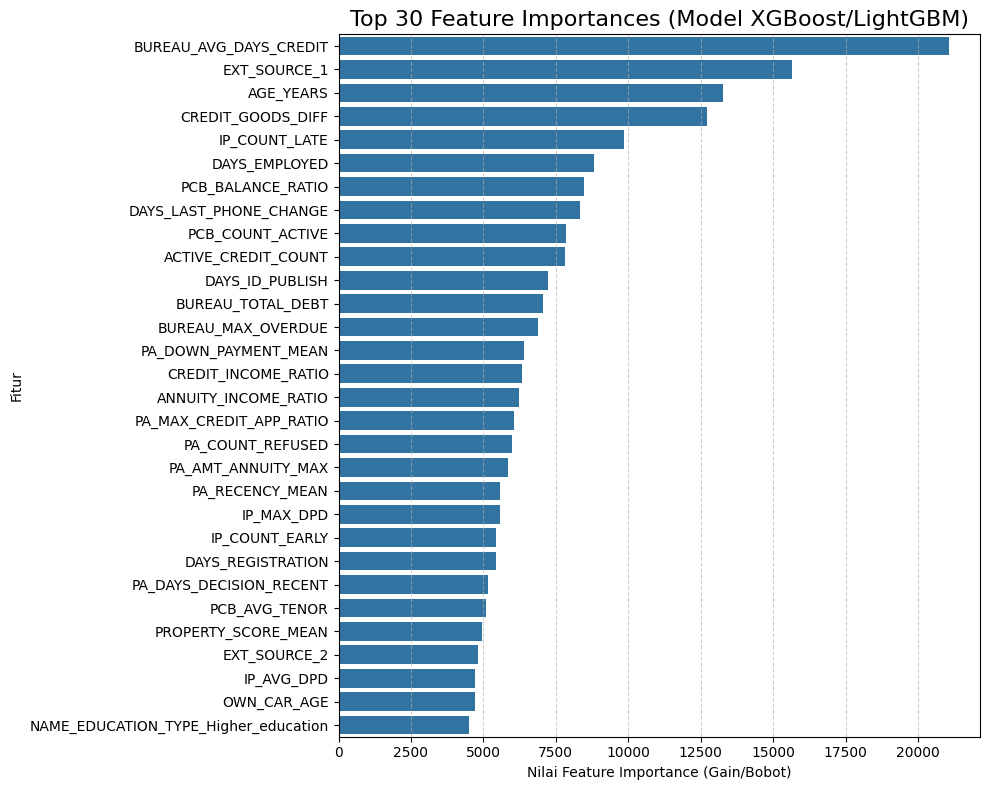

In [ ]:
# Pilih Top N Fitur (misalnya 30 teratas)
N = 30
top_n_features = feature_importance_df.head(N)

plt.figure(figsize=(10, 8))

# Buat Horizontal Bar Plot
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_n_features.sort_values(by='Importance', ascending=False),
    color='#1f77b4'
)

plt.title(f'Top {N} Feature Importances (Model XGBoost/LightGBM)', fontsize=16)
plt.xlabel('Nilai Feature Importance (Gain/Bobot)')
plt.ylabel('Fitur')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Tampilkan 50 fitur paling penting
print(feature_importance_df.head(50))

                                  Feature    Importance
176                BUREAU_AVG_DAYS_CREDIT  21087.896952
147                          EXT_SOURCE_1  15664.984697
48                              AGE_YEARS  13283.337921
10                      CREDIT_GOODS_DIFF  12726.538194
187                         IP_COUNT_LATE   9850.252954
46                          DAYS_EMPLOYED   8826.331920
201                     PCB_BALANCE_RATIO   8474.347114
156                DAYS_LAST_PHONE_CHANGE   8348.876792
197                      PCB_COUNT_ACTIVE   7852.803788
171                   ACTIVE_CREDIT_COUNT   7821.600653
50                        DAYS_ID_PUBLISH   7215.513636
169                     BUREAU_TOTAL_DEBT   7045.301830
173                    BUREAU_MAX_OVERDUE   6880.086713
210                  PA_DOWN_PAYMENT_MEAN   6388.353844
8                     CREDIT_INCOME_RATIO   6316.013679
9                    ANNUITY_INCOME_RATIO   6224.191617
208               PA_MAX_CREDIT_APP_RATIO   6053

In [ ]:
# 1. Pastikan DataFrame terurut berdasarkan Importance (descending)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 2. Hitung Proporsi (Normalisasi)
total_importance = feature_importance_df['Importance'].sum()
feature_importance_df['Proporsi'] = feature_importance_df['Importance'] / total_importance

# 3. Hitung Proporsi Kumulatif
feature_importance_df['Kumulatif'] = feature_importance_df['Proporsi'].cumsum()

print("Daftar Fitur dengan Kontribusi Kumulatif:")
print(feature_importance_df.head(10))

Daftar Fitur dengan Kontribusi Kumulatif:
                  Feature    Importance  Proporsi  Kumulatif
0  BUREAU_AVG_DAYS_CREDIT  21087.896952  0.064415   0.064415
1            EXT_SOURCE_1  15664.984697  0.047850   0.112266
2               AGE_YEARS  13283.337921  0.040575   0.152841
3       CREDIT_GOODS_DIFF  12726.538194  0.038875   0.191716
4           IP_COUNT_LATE   9850.252954  0.030089   0.221805
5           DAYS_EMPLOYED   8826.331920  0.026961   0.248766
6       PCB_BALANCE_RATIO   8474.347114  0.025886   0.274652
7  DAYS_LAST_PHONE_CHANGE   8348.876792  0.025503   0.300154
8        PCB_COUNT_ACTIVE   7852.803788  0.023987   0.324141
9     ACTIVE_CREDIT_COUNT   7821.600653  0.023892   0.348033


In [ ]:
# Tentukan Ambang Batas 99%
AMBANG_BATAS = 0.99

# Temukan indeks baris pertama yang melampaui ambang batas 99%
cutoff_index = feature_importance_df[feature_importance_df['Kumulatif'] >= AMBANG_BATAS].index.min()

# Ambil semua fitur hingga indeks tersebut (termasuk indeks tersebut)
features_to_keep = feature_importance_df.loc[:cutoff_index, 'Feature'].tolist()

# Hitung jumlah fitur yang tersisa
jumlah_fitur_terpilih = len(features_to_keep)

print("-" * 50)
print(f"Ambang Batas Seleksi: {AMBANG_BATAS*100:.0f}%")
print(f"Jumlah Fitur yang Menyumbang {AMBANG_BATAS*100:.0f}%: {jumlah_fitur_terpilih} kolom")
print(f"Total Kumulatif Bobot yang Dipertahankan: {feature_importance_df.loc[cutoff_index, 'Kumulatif']:.4f}")
print("-" * 50)

--------------------------------------------------
✅ Ambang Batas Seleksi: 99%
Jumlah Fitur yang Menyumbang 99%: 128 kolom
Total Kumulatif Bobot yang Dipertahankan: 0.9900
--------------------------------------------------


In [ ]:
top_features = features_to_keep
top_features.append("SK_ID_CURR")
top_features.append("TARGET")

# TRAINING : LOGISTIC REGRESSION

In [ ]:
df_train_model = df_train_final[top_features]
df_train_model

,BUREAU_AVG_DAYS_CREDIT,EXT_SOURCE_1,AGE_YEARS,CREDIT_GOODS_DIFF,IP_COUNT_LATE,DAYS_EMPLOYED,PCB_BALANCE_RATIO,DAYS_LAST_PHONE_CHANGE,PCB_COUNT_ACTIVE,ACTIVE_CREDIT_COUNT,...,WEEKDAY_APPR_PROCESS_START_THURSDAY,ORGANIZATION_TYPE_Trade_type_7,EMERGENCYSTATE_MODE_Yes,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_School,EXT_SOURCE_3_NA,ORGANIZATION_TYPE_Kindergarten,NAME_HOUSING_TYPE_Municipal_apartment,SK_ID_CURR,TARGET
0,-874.000000,0.083037,25.902806,-326299.5,0.000000,-637,0.625000,1134.0,19.0,2.0,...,0,0,0,0,0,0,0,0,100002,1
1,-1400.750000,0.311267,45.900068,-1093801.5,0.000000,-1188,0.544643,828.0,26.0,1.0,...,0,0,0,0,1,1,0,0,100003,0
2,-867.000000,0.505998,52.145106,-128250.0,0.000000,-225,0.562500,815.0,3.0,0.0,...,0,0,0,0,0,0,0,0,100004,0
3,0.000000,0.505998,52.032854,-267313.5,0.000000,-3039,0.570833,617.0,18.0,0.0,...,0,0,0,0,0,1,0,0,100006,0
4,-1149.000000,0.505998,54.570842,-491134.5,0.242424,-3038,0.557561,1106.0,62.0,0.0,...,1,0,0,0,0,1,0,0,100007,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.000000,0.145570,25.535934,-197442.0,0.000000,-236,0.546875,273.0,7.0,0.0,...,1,0,0,0,0,1,0,0,456251,0
307507,0.000000,0.505998,56.878850,-212998.5,0.166667,0,0.500000,0.0,6.0,0.0,...,0,0,0,0,0,1,0,0,456252,0
307508,-867.500000,0.744026,40.974675,-555021.0,0.071429,-7921,0.367647,1909.0,15.0,2.0,...,1,0,0,0,1,0,0,0,456253,0
307509,-1104.000000,0.505998,32.747433,-299295.0,0.000000,-4786,0.691071,322.0,20.0,0.0,...,0,0,0,0,0,0,0,0,456254,1


In [ ]:
# Pisahkan data untuk validasi

X = df_train_model.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df_train_model['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Membagi kolom berdasarkan kolom numerik dan kategorik
num_cols = "BUREAU_AVG_DAYS_CREDIT, AGE_YEARS, DAYS_EMPLOYED, DAYS_LAST_PHONE_CHANGE, DAYS_ID_PUBLISH, DAYS_REGISTRATION, OWN_CAR_AGE, PA_RECENCY_MEAN, PA_DAYS_DECISION_RECENT, B_CURR_MIN_BB_MIN_BAL, B_CURR_MEAN_BB_MIN_BAL, BUREAU_TOTAL_DEBT, BUREAU_MAX_OVERDUE, PA_DOWN_PAYMENT_MEAN, PA_AMT_ANNUITY_MAX, PA_AMT_GOODS_PRICE_SUM, BUREAU_TOTAL_ANNUITY, BUREAU_MAX_DPD_CURRENT, BUREAU_MAX_DPD_CURRENT, BUREAU_MAX_OVERDUE, BUREAU_TOTAL_ANNUITY, BUREAU_QUERY_TOTAL, INCOME_PER_FAMILY, HOUR_APPR_PROCESS_START, IP_COUNT_INSTALMENT, BUREAU_AVG_DAYS_CREDIT, AGE_YEARS, CREDIT_GOODS_DIFF, DAYS_EMPLOYED, DAYS_LAST_PHONE_CHANGE, DAYS_ID_PUBLISH, DAYS_REGISTRATION, PA_RECENCY_MEAN, PA_DAYS_DECISION_RECENT, OWN_CAR_AGE, CNT_CHILDREN, ACTIVE_CREDIT_COUNT, PA_COUNT_REFUSED, PCB_AVG_TENOR, IP_MAX_DPD, IP_AVG_DPD, BB_COUNT_RECENT_ACTIVE"
num_cols = list(set(num_cols.split(", ")))
cat_cols = X.drop(columns=num_cols, errors='ignore').columns.to_list()

In [ ]:
# Inisialisasi scaler
scaler = StandardScaler()

# Latih (Fit) scaler HANYA pada data train
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] =  scaler.fit_transform(X_test[num_cols])

print("StandardScaler berhasil dilatih pada data train.")

StandardScaler berhasil dilatih pada data train.


In [ ]:
# Inisialisasi Model Regresi Logistik

model_lr = LogisticRegression(
    C=0.01,
    penalty='l2',
    solver='liblinear',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

print("Memulai pelatihan model...")

# Latih model menggunakan data train
model_lr.fit(X_train, y_train)

print("Pelatihan selesai.")

Memulai pelatihan model...
Pelatihan selesai.


In [ ]:
# Prediksi Probabilitas
y_pred_proba = model_lr.predict_proba(X_test)[:, 1]

# Hitung Metrik Evaluasi Kunci
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Skor AUC-ROC: {auc_score:.4f}")
y_pred = (y_pred_proba >= 0.5).astype(int)

# 4. Hitung Recall
recall = recall_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)

print("Nilai recall : ", recall)
print("Nilai akurasi : ", accuracy)

Skor AUC-ROC: 0.7321
Nilai recall :  0.674479692867246
Nilai akurasi :  0.6621465619563274


# TRAINING : XGBoost

In [ ]:
X = df_train_model.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df_train_model['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Pemodelan menggunakan XGBoost
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=1500,
    learning_rate=0.02,
    max_depth=4,
    colsample_bytree = 0.97,
    gamma = 0.1,
    subsample= 0.85,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

print("\nMemulai pelatihan XGBoost...")
# Melatih model dengan Early Stopping
model_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
print("Pelatihan XGBoost selesai.")


Memulai pelatihan XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:09:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pelatihan XGBoost selesai.


In [ ]:
# Prediksi kelas secara langsung (menggunakan threshold default 0.5)
y_pred = model_xgb.predict(X_test)

# Prediksi Probabilitas pada Data Test
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Hitung AUC-ROC
auc_score_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"\n AUC-ROC Score XGBoost: {auc_score_xgb:.4f}")

# Hitung Recall
recall = recall_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n AUC-ROC Score XGBoost: {auc_score_xgb:.4f}")
print(f"\n Accuracy: {accuracy:.4f}")
print(f"\n Recall: {recall:.4f}")


 AUC-ROC Score XGBoost: 0.7601

 AUC-ROC Score XGBoost: 0.7601
Accuracy: 0.7120
Recall Baru: 0.6674


# TRAINING : RANDOM FOREST

In [ ]:

# Inisialisasi Model Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Memulai pelatihan Random Forest...")
# Latih model
rf_model.fit(X_train, y_train)
print("Pelatihan selesai.")

Memulai pelatihan Random Forest...
Pelatihan selesai.


In [ ]:
# Prediksi Probabilitas pada Data Test
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Nilai prediksi absolut
y_pred = rf_model.predict(X_test)

# Hitung Recall
recall = recall_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)

# Hitung AUC-ROC Score
auc_score_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\n AUC-ROC Score Random Forest: {auc_score_rf:.4f}")
print(f"\n Accuracy: {accuracy:.4f}")
print(f"\n Recall: {recall:.4f}")


 AUC-ROC Score Random Forest: 0.7270

 Accuracy: 0.7236

 Recall: 0.5910


# TRAINING : LIGHT GBM

In [ ]:
# Hitung bobot untuk kelas minoritas (TARGET=1)
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight = neg_count / pos_count

print(f"Scale Pos Weight (Bobot Kelas 1): {scale_pos_weight:.2f}")

Scale Pos Weight (Bobot Kelas 1): 11.38


In [ ]:
# Menentukan Parameter Model (Untuk klasifikasi biner)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.03,
    'num_leaves': 31,
    'max_depth': 7,
    'scale_pos_weight': scale_pos_weight,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

print("\nMemulai pelatihan LightGBM...")

# Pelatihan Model dengan Early Stopping
lgbm_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_test],
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)

print("Pelatihan LightGBM selesai.")


Memulai pelatihan LightGBM...
Pelatihan LightGBM selesai.


In [ ]:
# Prediksi Probabilitas pada Data Test
y_pred_proba_lgbm = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

# Hitung AUC-ROC
auc_score_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

# Nilai absolut prediksi
y_pred = (y_pred_proba_lgbm >= 0.5).astype(int)

# Hitung recall
recall = recall_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)

# Hitung AUC-ROC Score
auc_score_rf = roc_auc_score(y_test, y_pred_proba_lgbm)

print(f"\n AUC-ROC Score LightGBM: {auc_score_lgbm:.4f}")
print(f"\n Accuracy: {accuracy:.4f}")
print(f"\n Recall: {recall:.4f}")


 AUC-ROC Score LightGBM: 0.7482

 Accuracy: 0.6782

 Recall: 0.6937


# FEATURE IMPORTANCES FINAL

In [ ]:
# Membuat importances score untuk model xgb
importance_scores = model_xgb.feature_importances_
feature_names = model_xgb.get_booster().feature_names
feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    })

# Urutkan dan Tampilkan Top 20 Fitur teratas
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
feature_importance_df

,Feature,Importance
29,NAME_EDUCATION_TYPE_Higher_education,0.060848
30,REGION_RATING_CLIENT_W_CITY,0.036180
47,NAME_INCOME_TYPE_Working,0.035290
35,CODE_GENDER_F,0.027832
0,BUREAU_AVG_DAYS_CREDIT,0.027774
4,IP_COUNT_LATE,0.024978
67,CODE_GENDER_M,0.024858
1,EXT_SOURCE_1,0.022315
17,PA_COUNT_REFUSED,0.021672
44,FLAG_DOCUMENT_3,0.019422


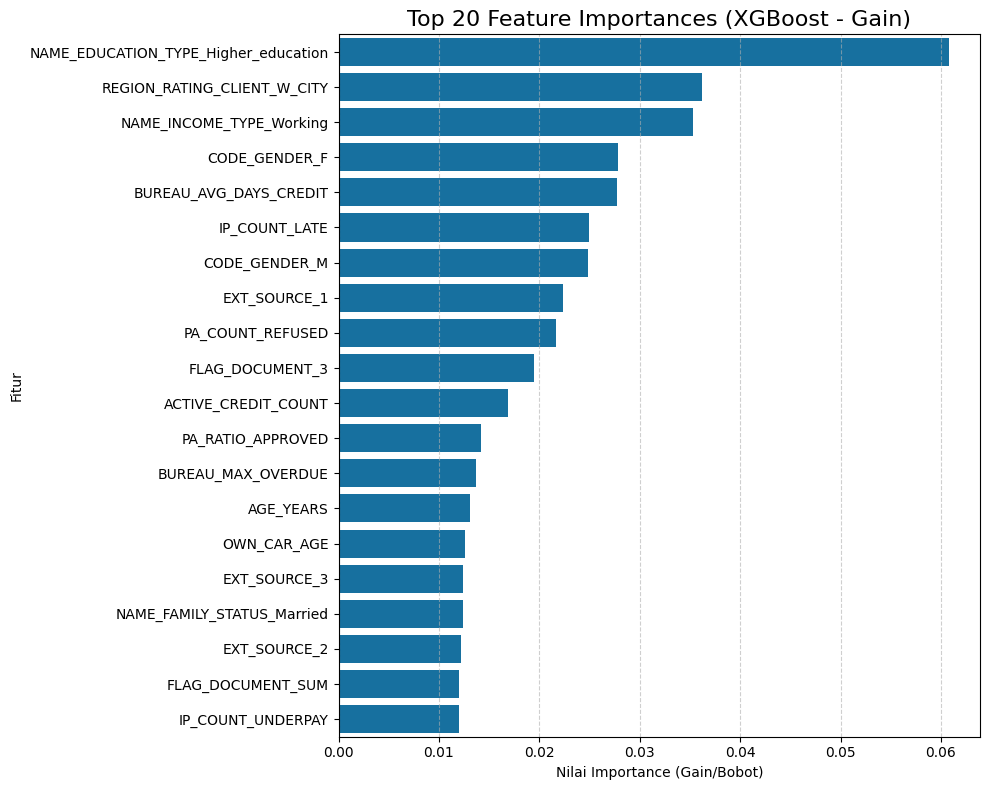

In [ ]:
# Membuat Bar Plot Horizontal
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.sort_values(by='Importance', ascending=False),
    color='#0077b6'
)
plt.title('Top 20 Feature Importances (XGBoost - Gain)', fontsize=16)
plt.xlabel('Nilai Importance (Gain/Bobot)')
plt.ylabel('Fitur')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()